In [3]:
# =============================================================================
# DISH DEMAND FORECASTER – MODEL COMPARISON NOTEBOOK
# Author: Your Name
# Date: 2025-10-27
# Goal: Compare R² scores of Random Forest, XGBoost, and Feedforward Neural Network
# =============================================================================

# --------------------------------------------------------------
# 1. IMPORTS & CONFIG
# --------------------------------------------------------------
import os
import re
import joblib
import warnings
from collections import Counter
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "../data/data.csv"
TOP_K = 100
LAGS = [1, 2, 3, 6, 12, 24]
WINDOWS = [3, 6, 12, 24]
USE_SCALER = True
TRAIN_FRAC = 0.8
RANDOM_STATE = 42
MODEL_DIR = "models"
CV_FOLDS = 5
os.makedirs(MODEL_DIR, exist_ok=True)

print("Configuration loaded.\n")

# --------------------------------------------------------------
# 2. PARSING UTILITIES
# --------------------------------------------------------------
def parse_order_items(order_str: str) -> List[Tuple[str, int]]:
    """Parse '2 x Pizza, 1 x Coke' → [('Pizza', 2), ('Coke', 1)]"""
    if pd.isna(order_str):
        return []
    return [(name.strip(), int(qty)) for qty, name in re.findall(r"(\d+)\s*[xX]\s*([^,]+)", order_str)]

def expand_items(df: pd.DataFrame) -> pd.DataFrame:
    """Expand 'Items in order' into a list of (item, qty) tuples."""
    df["expanded_items"] = df["Items in order"].fillna("").apply(parse_order_items)
    return df

print("Parsing utilities ready.\n")

# --------------------------------------------------------------
# 3. LOAD & PREPROCESS
# --------------------------------------------------------------
def load_and_prepare_data(path: str) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
    """Load and preprocess raw order data, returning DataFrame and restaurant menus."""
    df = pd.read_csv(path)
    print(f"Raw data: {df.shape[0]:,} rows, {df.shape[1]} columns")

    dt_col = next((col for col in df.columns
                   if "order" in col.lower() and ("placed" in col.lower() or "date" in col.lower())), None)
    if not dt_col:
        raise ValueError("No order datetime column found.")
    df["order_datetime"] = pd.to_datetime(df[dt_col], errors="coerce")
    df = df.dropna(subset=["order_datetime"]).copy()
    df["order_hour"] = df["order_datetime"].dt.floor("h")

    rest_col = "Restaurant name"
    if rest_col not in df.columns:
        raise ValueError(f"'{rest_col}' column not found.")
    df[rest_col] = df[rest_col].str.strip()
    unique_restaurants = df[rest_col].unique()
    print(f"Found {len(unique_restaurants)} restaurants: {list(unique_restaurants)}")
    df = pd.get_dummies(df, columns=[rest_col], prefix="rest", dtype=int)

    if "Items in order" not in df.columns:
        raise ValueError("'Items in order' column not found.")
    df = expand_items(df)

    rest_menus = {}
    rest_cols = [col for col in df.columns if col.startswith("rest_")]
    for rest_col in rest_cols:
        rest_name = rest_col[5:]  # Remove 'rest_' prefix
        rest_orders = df[df[rest_col] == 1]["expanded_items"]
        menu = set()
        for items in rest_orders:
            menu.update(item for item, _ in items)
        rest_menus[rest_name] = sorted(list(menu))
    print(f"Restaurant menus created: { {k: len(v) for k, v in rest_menus.items()} }")
    print("Swaad's menu:", rest_menus.get("Swaad", []))

    print(f"Pre-processed: {len(df):,} orders")
    return df, rest_menus

df, rest_menus = load_and_prepare_data(DATA_PATH)

# --------------------------------------------------------------
# 4. BUILD HOURLY AGGREGATED TABLE
# --------------------------------------------------------------
def build_hourly_table(df: pd.DataFrame, top_k: int) -> Tuple[pd.DataFrame, List[str]]:
    """Aggregate orders to hourly level with top-K dishes."""
    all_items = Counter()
    for items in df["expanded_items"]:
        all_items.update({item: qty for item, qty in items})
    top_dishes = [name for name, _ in all_items.most_common(top_k)]
    print(f"Top-{len(top_dishes)} dishes selected (sample: {top_dishes[:5]})")

    hour_idx = pd.date_range(
        start=df["order_hour"].min().floor("D"),
        end=df["order_hour"].max().ceil("D"),
        freq="h"
    )
    agg = pd.DataFrame(index=hour_idx)
    agg.index.name = "order_hour"

    agg["hour_of_day"] = agg.index.hour
    agg["day_of_week"] = agg.index.dayofweek
    agg["is_weekend"] = agg.index.dayofweek.isin([5, 6]).astype(int)

    for dish in top_dishes:
        agg[f"dish__{dish}"] = 0
    agg["total_orders"] = 0

    rest_cols = [col for col in df.columns if col.startswith("rest_")]
    for col in rest_cols:
        agg[col] = 0

    for hour, group in df.groupby("order_hour"):
        if hour not in agg.index:
            continue
        agg.loc[hour, "total_orders"] = len(group)
        for col in rest_cols:
            agg.loc[hour, col] = 1 if group[col].sum() > 0 else 0
        hour_counts = Counter()
        for items in group["expanded_items"]:
            hour_counts.update({item: qty for item, qty in items})
        for dish in top_dishes:
            agg.loc[hour, f"dish__{dish}"] = hour_counts.get(dish, 0)

    agg = agg[agg["total_orders"] > 0].copy()
    print(f"Aggregated {len(agg)} active hours.")
    return agg, top_dishes

agg, top_dishes = build_hourly_table(df, TOP_K)

# --------------------------------------------------------------
# 5. FEATURE ENGINEERING (lags + rolling)
# --------------------------------------------------------------
def add_temporal_features(agg: pd.DataFrame, lags: List[int], windows: List[int]) -> pd.DataFrame:
    """Add lag and rolling window features."""
    df = agg.copy()

    for lag in lags:
        df[f"total_orders_lag_{lag}"] = df["total_orders"].shift(lag)
        for dish in top_dishes:
            df[f"dish__{dish}_lag_{lag}"] = df[f"dish__{dish}"].shift(lag)

    for w in windows:
        df[f"total_orders_rollmean_{w}"] = df["total_orders"].rolling(w, min_periods=1).mean()
        for dish in top_dishes:
            df[f"dish__{dish}_rollmean_{w}"] = df[f"dish__{dish}"].rolling(w, min_periods=1).mean()

    df = df.dropna().reset_index()  # Keep order_hour as column
    print(f"Feature engineering → {df.shape[0]} rows, {df.shape[1]} cols")
    return df

agg_with_hour = add_temporal_features(agg, LAGS, WINDOWS)

# --------------------------------------------------------------
# 6. TRAIN / TEST SPLIT (time-based)
# --------------------------------------------------------------
def ensure_restaurant_coverage(train_agg: pd.DataFrame, test_agg: pd.DataFrame,
                              rest_cols: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Ensure all restaurants appear in training data."""
    train_rest = set([col for col in rest_cols if train_agg[col].sum() > 0])
    test_rest = set([col for col in rest_cols if test_agg[col].sum() > 0])
    missing = test_rest - train_rest
    if missing:
        print(f"Warning: {len(missing)} restaurants in test but not in train: {missing}")
        for col in missing:
            rest_data = test_agg[test_agg[col] == 1].head(1)
            if not rest_data.empty:
                train_agg = pd.concat([train_agg, rest_data])
                test_agg = test_agg.drop(rest_data.index)
        print("Adjusted train/test split to include all restaurants.")
    return train_agg, test_agg

split_time = agg_with_hour["order_hour"].quantile(TRAIN_FRAC)
train_agg = agg_with_hour[agg_with_hour["order_hour"] < split_time].copy()
test_agg = agg_with_hour[agg_with_hour["order_hour"] >= split_time].copy()
rest_cols = [col for col in agg_with_hour.columns if col.startswith("rest_")]
train_agg, test_agg = ensure_restaurant_coverage(train_agg, test_agg, rest_cols)
full_agg = agg_with_hour.set_index("order_hour")

print(f"Train hours: {len(train_agg)} | Test hours: {len(test_agg)}")

# --------------------------------------------------------------
# 7. FEATURE / TARGET LISTS
# --------------------------------------------------------------
feature_cols = [col for col in train_agg.columns if not col.startswith("dish__") and col != "order_hour"]
rest_cols = [col for col in feature_cols if col.startswith("rest_")]
target_cols = [f"dish__{dish}" for dish in top_dishes]

print(f"Features: {len(feature_cols)} (restaurants: {len(rest_cols)})")
print(f"Targets: {len(target_cols)}")

# --------------------------------------------------------------
# 8. MODEL COMPARISON
# --------------------------------------------------------------
def evaluate_model(model, model_name, X_train, Y_train, X_test, Y_test):
    """Train model and return test R² score."""
    multi_model = MultiOutputRegressor(model)
    multi_model.fit(X_train, Y_train)
    preds = multi_model.predict(X_test)
    r2 = r2_score(Y_test, preds, multioutput='uniform_average')
    print(f"{model_name} Test R²: {r2:.3f}")
    return r2

# Prepare data
if USE_SCALER:
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(train_agg[feature_cols]), columns=feature_cols)
    X_test_scaled = pd.DataFrame(scaler.transform(test_agg[feature_cols]), columns=feature_cols)
else:
    X_train_scaled = train_agg[feature_cols].copy()
    X_test_scaled = test_agg[feature_cols].copy()

Y_train = train_agg[target_cols].values
Y_test = test_agg[target_cols].values

# Models
models = {
    "Random Forest": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "Feedforward NN": MLPRegressor(random_state=RANDOM_STATE, max_iter=500)
}

# Evaluate all models
results = {}
for name, model in models.items():
    r2 = evaluate_model(model, name, X_train_scaled.values, Y_train, X_test_scaled.values, Y_test)
    results[name] = r2

# Print summary
print("\nModel Comparison Summary:")
for name, r2 in results.items():
    print(f"{name}: R² = {r2:.3f}")
best_model_name = max(results, key=results.get)
print(f"Best model: {best_model_name} with R² = {results[best_model_name]:.3f}")

# --------------------------------------------------------------
# 9. SAVE BEST MODEL
# --------------------------------------------------------------
best_model = MultiOutputRegressor(models[best_model_name])
best_model.fit(X_train_scaled.values, Y_train)
joblib.dump({
    "model": best_model,
    "scaler": scaler if USE_SCALER else None,
    "feature_cols": feature_cols,
    "target_cols": target_cols,
    "full_agg": full_agg
}, os.path.join(MODEL_DIR, "best_model_comparison.pkl"))

print(f"\nBest model saved → {MODEL_DIR}/best_model_comparison.pkl")

Configuration loaded.

Parsing utilities ready.

Raw data: 21,321 rows, 29 columns
Found 6 restaurants: ['Swaad', 'Aura Pizzas', 'Dilli Burger Adda', 'Tandoori Junction', 'The Chicken Junction', 'Masala Junction']
Restaurant menus created: {'Aura Pizzas': 76, 'Dilli Burger Adda': 64, 'Masala Junction': 13, 'Swaad': 94, 'Tandoori Junction': 37, 'The Chicken Junction': 21}
Swaad's menu: ['AAC Fried Chicken Burger', 'AAC Fried Paneer Burger', 'AAC Grilled Chicken Burger', 'AAC Grilled Chicken Burger .', 'AAC Grilled Paneer Burger', 'AAC Saucy Fries', 'AAC Signature Crisper Fries', 'AAC Signature Fries', 'AAC Signature Krispers', 'AAC Special Slaw', 'Angara Aloo Tuk Tuki', 'Angara Grilled Paneer (8 pcs)', 'Angara Rice', 'Angara Sauce', 'Animal Fries', 'Animal Fries .', 'Bone in Angara Grilled Chicken', 'Bone in Angara Grilled Chicken .', 'Bone in Jamaican Grilled Chicken', 'Bone in Jamaican Grilled Chicken .', 'Bone in Jamaican Grilled Chicken Quarter + Angara Rice', 'Bone in Kabuli Grille

In [2]:
# =============================================================================
# DISH DEMAND FORECASTER – RANDOM FOREST HYPERPARAMETER TUNING (OPTIMIZED)
# Author: Your Name
# Date: 2025-10-27
# Goal: Optimize Random Forest for predicting hourly demand for top-K dishes
# =============================================================================

# --------------------------------------------------------------
# 1. IMPORTS & CONFIG
# --------------------------------------------------------------
import os
import re
import joblib
import warnings
from collections import Counter
from typing import List, Tuple, Dict
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "../data/data.csv"
TOP_K = 50
LAGS = [1, 2, 3, 6, 12, 24]
WINDOWS = [3, 6, 12, 24]
USE_SCALER = True
TRAIN_FRAC = 0.8
RANDOM_STATE = 42
MODEL_DIR = "models"
CV_FOLDS = 3  # Reduced from 5 to speed up
os.makedirs(MODEL_DIR, exist_ok=True)

print("Configuration loaded.\n")

# --------------------------------------------------------------
# 2. PARSING UTILITIES
# --------------------------------------------------------------
def parse_order_items(order_str: str) -> List[Tuple[str, int]]:
    """Parse '2 x Pizza, 1 x Coke' → [('Pizza', 2), ('Coke', 1)]"""
    if pd.isna(order_str):
        return []
    return [(name.strip(), int(qty)) for qty, name in re.findall(r"(\d+)\s*[xX]\s*([^,]+)", order_str)]

def expand_items(df: pd.DataFrame) -> pd.DataFrame:
    """Expand 'Items in order' into a list of (item, qty) tuples."""
    df["expanded_items"] = df["Items in order"].fillna("").apply(parse_order_items)
    return df

print("Parsing utilities ready.\n")

# --------------------------------------------------------------
# 3. LOAD & PREPROCESS
# --------------------------------------------------------------
def load_and_prepare_data(path: str) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
    """Load and preprocess raw order data, returning DataFrame and restaurant menus."""
    df = pd.read_csv(path)
    print(f"Raw data: {df.shape[0]:,} rows, {df.shape[1]} columns")

    dt_col = next((col for col in df.columns
                   if "order" in col.lower() and ("placed" in col.lower() or "date" in col.lower())), None)
    if not dt_col:
        raise ValueError("No order datetime column found.")
    df["order_datetime"] = pd.to_datetime(df[dt_col], errors="coerce")
    df = df.dropna(subset=["order_datetime"]).copy()
    df["order_hour"] = df["order_datetime"].dt.floor("h")

    rest_col = "Restaurant name"
    if rest_col not in df.columns:
        raise ValueError(f"'{rest_col}' column not found.")
    df[rest_col] = df[rest_col].str.strip()
    unique_restaurants = df[rest_col].unique()
    print(f"Found {len(unique_restaurants)} restaurants: {list(unique_restaurants)}")
    df = pd.get_dummies(df, columns=[rest_col], prefix="rest", dtype=int)

    if "Items in order" not in df.columns:
        raise ValueError("'Items in order' column not found.")
    df = expand_items(df)

    rest_menus = {}
    rest_cols = [col for col in df.columns if col.startswith("rest_")]
    for rest_col in rest_cols:
        rest_name = rest_col[5:]  # Remove 'rest_' prefix
        rest_orders = df[df[rest_col] == 1]["expanded_items"]
        menu = set()
        for items in rest_orders:
            menu.update(item for item, _ in items)
        rest_menus[rest_name] = sorted(list(menu))
    print(f"Restaurant menus created: { {k: len(v) for k, v in rest_menus.items()} }")
    print("Swaad's menu:", rest_menus.get("Swaad", []))

    print(f"Pre-processed: {len(df):,} orders")
    return df, rest_menus

df, rest_menus = load_and_prepare_data(DATA_PATH)

# --------------------------------------------------------------
# 4. BUILD HOURLY AGGREGATED TABLE
# --------------------------------------------------------------
def build_hourly_table(df: pd.DataFrame, top_k: int) -> Tuple[pd.DataFrame, List[str]]:
    """Aggregate orders to hourly level with top-K dishes."""
    all_items = Counter()
    for items in df["expanded_items"]:
        all_items.update({item: qty for item, qty in items})
    top_dishes = [name for name, _ in all_items.most_common(top_k)]
    print(f"Top-{len(top_dishes)} dishes selected (sample: {top_dishes[:5]})")

    hour_idx = pd.date_range(
        start=df["order_hour"].min().floor("D"),
        end=df["order_hour"].max().ceil("D"),
        freq="h"
    )
    agg = pd.DataFrame(index=hour_idx)
    agg.index.name = "order_hour"

    agg["hour_of_day"] = agg.index.hour
    agg["day_of_week"] = agg.index.dayofweek
    agg["is_weekend"] = agg.index.dayofweek.isin([5, 6]).astype(int)

    for dish in top_dishes:
        agg[f"dish__{dish}"] = 0
    agg["total_orders"] = 0

    rest_cols = [col for col in df.columns if col.startswith("rest_")]
    for col in rest_cols:
        agg[col] = 0

    for hour, group in df.groupby("order_hour"):
        if hour not in agg.index:
            continue
        agg.loc[hour, "total_orders"] = len(group)
        for col in rest_cols:
            agg.loc[hour, col] = 1 if group[col].sum() > 0 else 0
        hour_counts = Counter()
        for items in group["expanded_items"]:
            hour_counts.update({item: qty for item, qty in items})
        for dish in top_dishes:
            agg.loc[hour, f"dish__{dish}"] = hour_counts.get(dish, 0)

    agg = agg[agg["total_orders"] > 0].copy()
    print(f"Aggregated {len(agg)} active hours.")
    return agg, top_dishes

agg, top_dishes = build_hourly_table(df, TOP_K)

# --------------------------------------------------------------
# 5. FEATURE ENGINEERING (lags + rolling)
# --------------------------------------------------------------
def add_temporal_features(agg: pd.DataFrame, lags: List[int], windows: List[int]) -> pd.DataFrame:
    """Add lag and rolling window features."""
    df = agg.copy()

    for lag in lags:
        df[f"total_orders_lag_{lag}"] = df["total_orders"].shift(lag)
        for dish in top_dishes:
            df[f"dish__{dish}_lag_{lag}"] = df[f"dish__{dish}"].shift(lag)

    for w in windows:
        df[f"total_orders_rollmean_{w}"] = df["total_orders"].rolling(w, min_periods=1).mean()
        for dish in top_dishes:
            df[f"dish__{dish}_rollmean_{w}"] = df[f"dish__{dish}"].rolling(w, min_periods=1).mean()

    df = df.dropna().reset_index()  # Keep order_hour as column
    print(f"Feature engineering → {df.shape[0]} rows, {df.shape[1]} cols")
    return df

agg_with_hour = add_temporal_features(agg, LAGS, WINDOWS)

# --------------------------------------------------------------
# 6. TRAIN / TEST SPLIT (time-based)
# --------------------------------------------------------------
def ensure_restaurant_coverage(train_agg: pd.DataFrame, test_agg: pd.DataFrame,
                              rest_cols: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Ensure all restaurants appear in training data."""
    train_rest = set([col for col in rest_cols if train_agg[col].sum() > 0])
    test_rest = set([col for col in rest_cols if test_agg[col].sum() > 0])
    missing = test_rest - train_rest
    if missing:
        print(f"Warning: {len(missing)} restaurants in test but not in train: {missing}")
        for col in missing:
            rest_data = test_agg[test_agg[col] == 1].head(1)
            if not rest_data.empty:
                train_agg = pd.concat([train_agg, rest_data])
                test_agg = test_agg.drop(rest_data.index)
        print("Adjusted train/test split to include all restaurants.")
    return train_agg, test_agg

split_time = agg_with_hour["order_hour"].quantile(TRAIN_FRAC)
train_agg = agg_with_hour[agg_with_hour["order_hour"] < split_time].copy()
test_agg = agg_with_hour[agg_with_hour["order_hour"] >= split_time].copy()
rest_cols = [col for col in agg_with_hour.columns if col.startswith("rest_")]
train_agg, test_agg = ensure_restaurant_coverage(train_agg, test_agg, rest_cols)
full_agg = agg_with_hour.set_index("order_hour")

print(f"Train hours: {len(train_agg)} | Test hours: {len(test_agg)}")

# --------------------------------------------------------------
# 7. FEATURE / TARGET LISTS
# --------------------------------------------------------------
feature_cols = [col for col in train_agg.columns if not col.startswith("dish__") and col != "order_hour"]
rest_cols = [col for col in feature_cols if col.startswith("rest_")]
target_cols = [f"dish__{dish}" for dish in top_dishes]

print(f"Features: {len(feature_cols)} (restaurants: {len(rest_cols)})")
print(f"Targets: {len(target_cols)}")

# --------------------------------------------------------------
# 8. HYPERPARAMETER TUNING FOR RANDOM FOREST
# --------------------------------------------------------------
def tune_random_forest(X: np.ndarray, Y: np.ndarray, cv_splits):
    """Tune Random Forest hyperparameters using GridSearchCV for multi-output."""
    base_estimator = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=2)  # Reduced from -1
    model = MultiOutputRegressor(base_estimator)

    param_grid = {
        'estimator__n_estimators': [100, 200],  # Reduced from [100, 200, 300]
        'estimator__max_depth': [10, 20],      # Reduced from [10, 20, 30, None]
        'estimator__min_samples_split': [2, 5], # Reduced from [2, 5, 10]
        'estimator__min_samples_leaf': [1, 2]   # Reduced from [1, 2, 4]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        cv=cv_splits,
        n_jobs=2,  # Reduced from -1
        verbose=1
    )

    print("Starting hyperparameter tuning for Random Forest...")
    start_time = time.time()
    grid_search.fit(X, Y)
    end_time = time.time()
    print(f"Tuning completed in {int((end_time - start_time) // 60)}m {int((end_time - start_time) % 60)}s")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV R²: {grid_search.best_score_:.3f}")
    return grid_search.best_estimator_

# Prepare data
if USE_SCALER:
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(train_agg[feature_cols]), columns=feature_cols)
    X_test_scaled = pd.DataFrame(scaler.transform(test_agg[feature_cols]), columns=feature_cols)
else:
    X_train_scaled = train_agg[feature_cols].copy()
    X_test_scaled = test_agg[feature_cols].copy()

Y_train = train_agg[target_cols].values
Y_test = test_agg[target_cols].values

tscv = TimeSeriesSplit(n_splits=CV_FOLDS)
best_rf_model = tune_random_forest(X_train_scaled.values, Y_train, tscv)

# --------------------------------------------------------------
# 9. EVALUATE ON TEST SET
# --------------------------------------------------------------
preds = best_rf_model.predict(X_test_scaled.values)
test_r2 = r2_score(Y_test, preds, multioutput='uniform_average')
print(f"\nTest R² with best Random Forest: {test_r2:.3f}")

# --------------------------------------------------------------
# 10. SAVE MODEL
# --------------------------------------------------------------
joblib.dump({
    "model": best_rf_model,
    "scaler": scaler if USE_SCALER else None,
    "feature_cols": feature_cols,
    "target_cols": target_cols,
    "full_agg": full_agg
}, os.path.join(MODEL_DIR, "best_rf_tuned_optimized.pkl"))

print(f"\nModel saved → {MODEL_DIR}/best_rf_tuned_optimized.pkl")

Configuration loaded.

Parsing utilities ready.

Raw data: 21,321 rows, 29 columns
Found 6 restaurants: ['Swaad', 'Aura Pizzas', 'Dilli Burger Adda', 'Tandoori Junction', 'The Chicken Junction', 'Masala Junction']
Restaurant menus created: {'Aura Pizzas': 76, 'Dilli Burger Adda': 64, 'Masala Junction': 13, 'Swaad': 94, 'Tandoori Junction': 37, 'The Chicken Junction': 21}
Swaad's menu: ['AAC Fried Chicken Burger', 'AAC Fried Paneer Burger', 'AAC Grilled Chicken Burger', 'AAC Grilled Chicken Burger .', 'AAC Grilled Paneer Burger', 'AAC Saucy Fries', 'AAC Signature Crisper Fries', 'AAC Signature Fries', 'AAC Signature Krispers', 'AAC Special Slaw', 'Angara Aloo Tuk Tuki', 'Angara Grilled Paneer (8 pcs)', 'Angara Rice', 'Angara Sauce', 'Animal Fries', 'Animal Fries .', 'Bone in Angara Grilled Chicken', 'Bone in Angara Grilled Chicken .', 'Bone in Jamaican Grilled Chicken', 'Bone in Jamaican Grilled Chicken .', 'Bone in Jamaican Grilled Chicken Quarter + Angara Rice', 'Bone in Kabuli Grille

In [14]:
# =============================================================================
# DISH DEMAND FORECASTER – MULTI-MODEL COMPARISON WITH AGGREGATED DATA
# Author: Your Name
# Date: 2025-10-27
# Goal: Predict dish demand using temporal features and compare Random Forest, XGBoost, MLP
# =============================================================================

# --------------------------------------------------------------
# 1. IMPORTS & CONFIG
# --------------------------------------------------------------
import os
import re
import joblib
import warnings
from collections import Counter
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "../data/data.csv"
TOP_K = 10  # Top 10 dishes across all restaurants
TRAIN_FRAC = 0.8
RANDOM_STATE = 42
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Configuration loaded.\n")

# --------------------------------------------------------------
# 2. PARSING UTILITIES
# --------------------------------------------------------------
def parse_order_items(order_str: str) -> List[Tuple[str, int]]:
    """Parse '2 x Pizza, 1 x Coke' → [('Pizza', 2), ('Coke', 1)]"""
    if pd.isna(order_str):
        return []
    return [(name.strip(), int(qty)) for qty, name in re.findall(r"(\d+)\s*[xX]\s*([^,]+)", order_str)]

def expand_items(df: pd.DataFrame) -> pd.DataFrame:
    """Expand 'Items in order' into a list of (item, qty) tuples."""
    df["expanded_items"] = df["Items in order"].fillna("").apply(parse_order_items)
    return df

print("Parsing utilities ready.\n")

# --------------------------------------------------------------
# 3. LOAD & PREPROCESS
# --------------------------------------------------------------
def load_and_prepare_data(path: str) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
    """Load and preprocess raw order data, returning DataFrame and restaurant menus."""
    df = pd.read_csv(path)
    print(f"Raw data: {df.shape[0]:,} rows, {df.shape[1]} columns")

    dt_col = next((c for c in df.columns
                   if "order" in c.lower() and ("placed" in c.lower() or "date" in c.lower())), None)
    if not dt_col:
        raise ValueError("No order datetime column found.")
    df["order_datetime"] = pd.to_datetime(df[dt_col], errors="coerce")
    df = df.dropna(subset=["order_datetime"]).copy()
    df["order_hour"] = df["order_datetime"].dt.floor("h")

    rest_col = "Restaurant name"
    if rest_col not in df.columns:
        raise ValueError(f"'{rest_col}' column not found.")
    df[rest_col] = df[rest_col].str.strip()
    unique_restaurants = df[rest_col].unique()
    print(f"Found {len(unique_restaurants)} restaurants: {list(unique_restaurants)}")
    df = pd.get_dummies(df, columns=[rest_col], prefix="rest", dtype=int)

    if "Items in order" not in df.columns:
        raise ValueError("'Items in order' column not found.")
    df = expand_items(df)

    rest_menus = {}
    rest_cols = [c for c in df.columns if c.startswith("rest_")]
    for rest_col in rest_cols:
        rest_name = rest_col[5:]
        rest_orders = df[df[rest_col] == 1]["expanded_items"]
        menu = set()
        for items in rest_orders:
            menu.update(name for name, _ in items)
        rest_menus[rest_name] = sorted(list(menu))
    print(f"Restaurant menus created: { {k: len(v) for k, v in rest_menus.items()} }")
    print("Swaad's menu:", rest_menus.get("Swaad", []))

    print(f"Pre-processed: {len(df):,} orders")
    return df, rest_menus, rest_cols

df, rest_menus, rest_cols = load_and_prepare_data(DATA_PATH)

# --------------------------------------------------------------
# 4. BUILD HOURLY AGGREGATED TABLE
# --------------------------------------------------------------
def build_hourly_table(df: pd.DataFrame, top_k: int, rest_cols: List[str]) -> pd.DataFrame:
    """Aggregate orders to hourly level with top-K dishes across all restaurants."""
    all_items = Counter()
    for items in df["expanded_items"]:
        all_items.update({name: qty for name, qty in items})
    top_dishes = [name for name, _ in all_items.most_common(top_k)]
    print(f"Top-{top_k} dishes across all restaurants: {top_dishes[:5]}")

    hour_idx = pd.date_range(
        start=df["order_hour"].min().floor("D"),
        end=df["order_hour"].max().ceil("D"),
        freq="h"
    )
    agg = pd.DataFrame(index=hour_idx)
    agg.index.name = "order_hour"

    agg["is_weekend"] = agg.index.dayofweek.isin([5, 6]).astype(int)
    agg["day_of_week"] = agg.index.dayofweek
    agg["hour_of_day"] = agg.index.hour
    agg["month"] = agg.index.month
    for col in rest_cols:
        agg[col] = 0

    for dish in top_dishes:
        agg[f"dish__{dish}"] = 0
    agg["total_orders"] = 0

    for hour, group in df.groupby("order_hour"):
        if hour not in agg.index:
            continue
        agg.loc[hour, "total_orders"] = len(group)
        for col in rest_cols:
            agg.loc[hour, col] = 1 if group[col].sum() > 0 else 0
        hour_counts = Counter()
        for items in group["expanded_items"]:
            hour_counts.update({name: qty for name, qty in items})
        for dish in top_dishes:
            agg.loc[hour, f"dish__{dish}"] = hour_counts.get(dish, 0)

    agg = agg[agg["total_orders"] > 0].copy()
    print(f"Aggregated {len(agg)} active hours.")
    return agg, top_dishes

agg, top_dishes = build_hourly_table(df, TOP_K, rest_cols)

# --------------------------------------------------------------
# 5. TRAIN / TEST SPLIT (time-based)
# --------------------------------------------------------------
def split_data(agg: pd.DataFrame, train_frac: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Split data into train and test sets based on time fraction."""
    indices = agg.index
    split_idx = int(len(indices) * train_frac)
    split_time = indices[split_idx]
    train_agg = agg[agg.index < split_time].copy()
    test_agg = agg[agg.index >= split_time].copy()
    return train_agg, test_agg

train_agg, test_agg = split_data(agg, TRAIN_FRAC)
print(f"Train hours: {len(train_agg):,} | Test hours: {len(test_agg):,}")

# --------------------------------------------------------------
# 6. MODELING AND COMPARISON
# --------------------------------------------------------------
results = {}
feature_cols = ["is_weekend", "day_of_week", "hour_of_day", "month"] + rest_cols
target_cols = [col for col in agg.columns if col.startswith("dish__")]

X_train = train_agg[feature_cols]
Y_train = train_agg[target_cols]
X_test = test_agg[feature_cols]
Y_test = test_agg[target_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "random_forest": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "xgboost": xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, objective="reg:squarederror"),
    "mlp": MLPRegressor(random_state=RANDOM_STATE, max_iter=500, early_stopping=True)
}

param_grids = {
    "random_forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10],
        "min_samples_split": [2, 5]
    },
    "xgboost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5],
        "learning_rate": [0.01, 0.1]
    },
    "mlp": {
        "hidden_layer_sizes": [(50,), (100,)],
        "alpha": [0.0001, 0.001]
    }
}

tscv = TimeSeriesSplit(n_splits=3)

for model_name, base_estimator in models.items():
    print(f"\nTraining and tuning {model_name}...")
    grid_search = GridSearchCV(
        estimator=base_estimator,
        param_grid=param_grids[model_name],
        scoring="r2",
        cv=tscv,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_scaled, Y_train.iloc[:, 0])  # Tune on first target
    print(f"Best params for {model_name}: {grid_search.best_params_}")
    print(f"CV R² for {model_name}: {grid_search.best_score_:.3f}")

    model = MultiOutputRegressor(grid_search.best_estimator_)
    model.fit(X_train_scaled, Y_train)
    preds = model.predict(X_test_scaled)
    test_r2 = r2_score(Y_test, preds, multioutput="uniform_average")
    print(f"Test R² for {model_name}: {test_r2:.3f}")

    # Save model
    joblib.dump({
        "model": model,
        "scaler": scaler,
        "feature_cols": feature_cols,
        "target_cols": target_cols
    }, os.path.join(MODEL_DIR, f"{model_name}.pkl"))
    results[model_name] = test_r2

# --------------------------------------------------------------
# 7. SUMMARY
# --------------------------------------------------------------
print("\nModel Comparison Summary:")
for model_name, r2 in results.items():
    print(f"{model_name}: R² = {r2:.3f}")
best_model = max(results, key=results.get)
print(f"Best model: {best_model} with R² = {results[best_model]:.3f}")

# Save results
joblib.dump(results, os.path.join(MODEL_DIR, "model_comparison_results.pkl"))
print(f"\nResults saved → {MODEL_DIR}/model_comparison_results.pkl")

Configuration loaded.

Parsing utilities ready.

Raw data: 21,321 rows, 29 columns
Found 6 restaurants: ['Swaad', 'Aura Pizzas', 'Dilli Burger Adda', 'Tandoori Junction', 'The Chicken Junction', 'Masala Junction']
Restaurant menus created: {'Aura Pizzas': 76, 'Dilli Burger Adda': 64, 'Masala Junction': 13, 'Swaad': 94, 'Tandoori Junction': 37, 'The Chicken Junction': 21}
Swaad's menu: ['AAC Fried Chicken Burger', 'AAC Fried Paneer Burger', 'AAC Grilled Chicken Burger', 'AAC Grilled Chicken Burger .', 'AAC Grilled Paneer Burger', 'AAC Saucy Fries', 'AAC Signature Crisper Fries', 'AAC Signature Fries', 'AAC Signature Krispers', 'AAC Special Slaw', 'Angara Aloo Tuk Tuki', 'Angara Grilled Paneer (8 pcs)', 'Angara Rice', 'Angara Sauce', 'Animal Fries', 'Animal Fries .', 'Bone in Angara Grilled Chicken', 'Bone in Angara Grilled Chicken .', 'Bone in Jamaican Grilled Chicken', 'Bone in Jamaican Grilled Chicken .', 'Bone in Jamaican Grilled Chicken Quarter + Angara Rice', 'Bone in Kabuli Grille

Configuration loaded.

Parsing utilities ready.

Raw data: 21,321 rows, 29 columns
Restaurant menus created: {'Aura Pizzas': 76, 'Dilli Burger Adda': 64, 'Masala Junction': 13, 'Swaad': 94, 'Tandoori Junction': 37, 'The Chicken Junction': 21}
Swaad's menu: ['AAC Fried Chicken Burger', 'AAC Fried Paneer Burger', 'AAC Grilled Chicken Burger', 'AAC Grilled Chicken Burger .', 'AAC Grilled Paneer Burger', 'AAC Saucy Fries', 'AAC Signature Crisper Fries', 'AAC Signature Fries', 'AAC Signature Krispers', 'AAC Special Slaw', 'Angara Aloo Tuk Tuki', 'Angara Grilled Paneer (8 pcs)', 'Angara Rice', 'Angara Sauce', 'Animal Fries', 'Animal Fries .', 'Bone in Angara Grilled Chicken', 'Bone in Angara Grilled Chicken .', 'Bone in Jamaican Grilled Chicken', 'Bone in Jamaican Grilled Chicken .', 'Bone in Jamaican Grilled Chicken Quarter + Angara Rice', 'Bone in Kabuli Grilled Chicken', 'Bone in Peri Peri Grilled Chicken', 'Bone in Peri Peri Grilled Chicken .', 'Bone in Smoky Bbq Grilled Chicken', 'Bone 

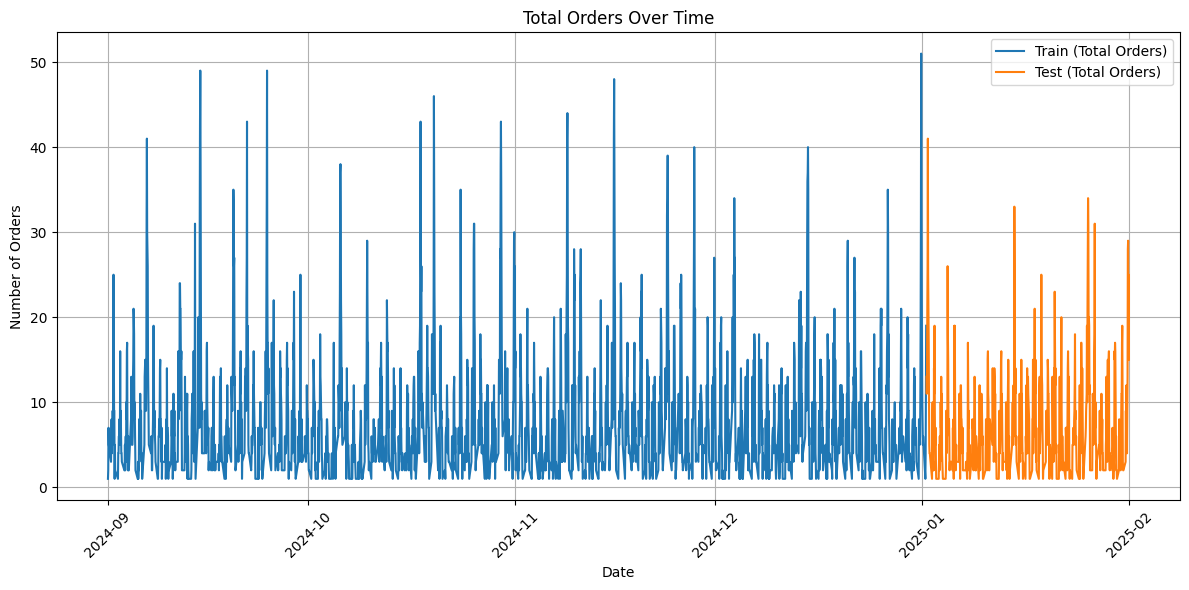

dish__Bageecha Pizza: Mean = 1.41, Std = 2.10, Zeros = 837
dish__Chilli Cheese Garlic Bread: Mean = 0.81, Std = 1.19, Zeros = 1105
dish__Bone in Jamaican Grilled Chicken: Mean = 0.72, Std = 1.32, Zeros = 1221
dish__All About Chicken Pizza: Mean = 0.72, Std = 1.27, Zeros = 1248
dish__Makhani Paneer Pizza: Mean = 0.61, Std = 1.13, Zeros = 1307
dish__Margherita Pizza: Mean = 0.60, Std = 1.13, Zeros = 1319
dish__Cheesy Garlic Bread: Mean = 0.55, Std = 1.03, Zeros = 1362
dish__Jamaican Chicken Melt: Mean = 0.50, Std = 0.95, Zeros = 1386
dish__Herbed Potato: Mean = 0.39, Std = 0.82, Zeros = 1529
dish__Tripple Cheese Pizza: Mean = 0.32, Std = 0.75, Zeros = 1592

Train Total Orders - Mean: 8.50, Std: 7.20
Test Total Orders - Mean: 7.72, Std: 6.00
Mean Predictor Baseline Test R²: -0.047

Results saved → models/baseline_diagnostics.pkl


In [16]:
# =============================================================================
# DISH DEMAND FORECASTER – DATA DIAGNOSTICS AND BASELINE
# Author: Your Name
# Date: 2025-10-27
# Goal: Diagnose data issues and establish a baseline with mean predictor
# =============================================================================

# --------------------------------------------------------------
# 1. IMPORTS & CONFIG
# --------------------------------------------------------------
import os
import re
import joblib
import warnings
from collections import Counter
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "../data/data.csv"
TOP_K = 10  # Top 10 dishes across all restaurants
TRAIN_FRAC = 0.8
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Configuration loaded.\n")

# --------------------------------------------------------------
# 2. PARSING UTILITIES
# --------------------------------------------------------------
def parse_order_items(order_str: str) -> List[Tuple[str, int]]:
    """Parse '2 x Pizza, 1 x Coke' → [('Pizza', 2), ('Coke', 1)]"""
    if pd.isna(order_str):
        return []
    return [(name.strip(), int(qty)) for qty, name in re.findall(r"(\d+)\s*[xX]\s*([^,]+)", order_str)]

def expand_items(df: pd.DataFrame) -> pd.DataFrame:
    """Expand 'Items in order' into a list of (item, qty) tuples."""
    df["expanded_items"] = df["Items in order"].fillna("").apply(parse_order_items)
    return df

print("Parsing utilities ready.\n")

# --------------------------------------------------------------
# 3. LOAD & PREPROCESS
# --------------------------------------------------------------
def load_and_prepare_data(path: str) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
    """Load and preprocess raw order data, returning DataFrame and restaurant menus."""
    df = pd.read_csv(path)
    print(f"Raw data: {df.shape[0]:,} rows, {df.shape[1]} columns")

    dt_col = next((c for c in df.columns
                   if "order" in c.lower() and ("placed" in c.lower() or "date" in c.lower())), None)
    if not dt_col:
        raise ValueError("No order datetime column found.")
    df["order_datetime"] = pd.to_datetime(df[dt_col], errors="coerce")
    df = df.dropna(subset=["order_datetime"]).copy()
    df["order_hour"] = df["order_datetime"].dt.floor("h")

    rest_col = "Restaurant name"
    if rest_col not in df.columns:
        raise ValueError(f"'{rest_col}' column not found.")
    df[rest_col] = df[rest_col].str.strip()
    unique_restaurants = df[rest_col].unique()
    df = pd.get_dummies(df, columns=[rest_col], prefix="rest", dtype=int)

    if "Items in order" not in df.columns:
        raise ValueError("'Items in order' column not found.")
    df = expand_items(df)

    rest_menus = {}
    rest_cols = [c for c in df.columns if c.startswith("rest_")]
    for rest_col in rest_cols:
        rest_name = rest_col[5:]
        rest_orders = df[df[rest_col] == 1]["expanded_items"]
        menu = set()
        for items in rest_orders:
            menu.update(name for name, _ in items)
        rest_menus[rest_name] = sorted(list(menu))
    print(f"Restaurant menus created: { {k: len(v) for k, v in rest_menus.items()} }")
    print("Swaad's menu:", rest_menus.get("Swaad", []))

    print(f"Pre-processed: {len(df):,} orders")
    return df, rest_menus, rest_cols

df, rest_menus, rest_cols = load_and_prepare_data(DATA_PATH)

# --------------------------------------------------------------
# 4. BUILD HOURLY AGGREGATED TABLE
# --------------------------------------------------------------
def build_hourly_table(df: pd.DataFrame, top_k: int, rest_cols: List[str]) -> pd.DataFrame:
    """Aggregate orders to hourly level with top-K dishes across all restaurants."""
    all_items = Counter()
    for items in df["expanded_items"]:
        all_items.update({name: qty for name, qty in items})
    top_dishes = [name for name, _ in all_items.most_common(top_k)]
    print(f"Top-{top_k} dishes across all restaurants: {top_dishes[:5]}")

    hour_idx = pd.date_range(
        start=df["order_hour"].min().floor("D"),
        end=df["order_hour"].max().ceil("D"),
        freq="h"
    )
    agg = pd.DataFrame(index=hour_idx)
    agg.index.name = "order_hour"

    agg["is_weekend"] = agg.index.dayofweek.isin([5, 6]).astype(int)
    agg["day_of_week"] = agg.index.dayofweek
    agg["hour_of_day"] = agg.index.hour
    agg["month"] = agg.index.month
    for col in rest_cols:
        agg[col] = 0

    for dish in top_dishes:
        agg[f"dish__{dish}"] = 0
    agg["total_orders"] = 0

    for hour, group in df.groupby("order_hour"):
        if hour not in agg.index:
            continue
        agg.loc[hour, "total_orders"] = len(group)
        for col in rest_cols:
            agg.loc[hour, col] = 1 if group[col].sum() > 0 else 0
        hour_counts = Counter()
        for items in group["expanded_items"]:
            hour_counts.update({name: qty for name, qty in items})
        for dish in top_dishes:
            agg.loc[hour, f"dish__{dish}"] = hour_counts.get(dish, 0)

    agg = agg[agg["total_orders"] > 0].copy()
    print(f"Aggregated {len(agg)} active hours.")
    return agg, top_dishes

agg, top_dishes = build_hourly_table(df, TOP_K, rest_cols)

# --------------------------------------------------------------
# 5. TRAIN / TEST SPLIT (time-based)
# --------------------------------------------------------------
def split_data(agg: pd.DataFrame, train_frac: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Split data into train and test sets based on time fraction."""
    indices = agg.index
    split_idx = int(len(indices) * train_frac)
    split_time = indices[split_idx]
    train_agg = agg[agg.index < split_time].copy()
    test_agg = agg[agg.index >= split_time].copy()
    return train_agg, test_agg

train_agg, test_agg = split_data(agg, TRAIN_FRAC)
print(f"Train hours: {len(train_agg):,} | Test hours: {len(test_agg):,}")

# --------------------------------------------------------------
# 6. DATA DIAGNOSTICS
# --------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(train_agg.index, train_agg["total_orders"], label="Train (Total Orders)")
plt.plot(test_agg.index, test_agg["total_orders"], label="Test (Total Orders)")
plt.title("Total Orders Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, "total_orders.png"))
plt.show()

# Statistics per dish
dish_cols = [col for col in agg.columns if col.startswith("dish__")]
dish_stats = {col: train_agg[col].describe() for col in dish_cols}
for dish, stats in dish_stats.items():
    print(f"{dish}: Mean = {stats['mean']:.2f}, Std = {stats['std']:.2f}, Zeros = {(train_agg[dish] == 0).sum()}")

# Train vs Test comparison
train_mean = train_agg["total_orders"].mean()
train_std = train_agg["total_orders"].std()
test_mean = test_agg["total_orders"].mean()
test_std = test_agg["total_orders"].std()
print(f"\nTrain Total Orders - Mean: {train_mean:.2f}, Std: {train_std:.2f}")
print(f"Test Total Orders - Mean: {test_mean:.2f}, Std: {test_std:.2f}")

# --------------------------------------------------------------
# 7. MEAN PREDICTOR BASELINE
# --------------------------------------------------------------
def mean_predictor_baseline(train_agg: pd.DataFrame, test_agg: pd.DataFrame, target_cols: List[str]) -> float:
    """Compute baseline predictions using mean per feature combination and evaluate R²."""
    # Group by features to compute mean demand per combination
    feature_cols = ["is_weekend", "day_of_week", "hour_of_day", "month"] + rest_cols
    grouped = train_agg.groupby(feature_cols)[target_cols].mean().reset_index()

    preds = []
    for _, row in test_agg.iterrows():
        feature_values = row[feature_cols].values
        match = grouped[(grouped[feature_cols] == feature_values).all(axis=1)]
        if not match.empty:
            pred = match[target_cols].iloc[0].values
        else:
            pred = train_agg[target_cols].mean().values  # Fallback to global mean
        preds.append(pred)

    preds = np.array(preds)
    test_r2 = r2_score(test_agg[target_cols], preds, multioutput="uniform_average")
    print(f"Mean Predictor Baseline Test R²: {test_r2:.3f}")
    return test_r2

target_cols = [col for col in agg.columns if col.startswith("dish__")]
test_r2_baseline = mean_predictor_baseline(train_agg, test_agg, target_cols)

# --------------------------------------------------------------
# 8. SAVE RESULTS
# --------------------------------------------------------------
joblib.dump({
    "train_agg": train_agg,
    "test_agg": test_agg,
    "dish_stats": dish_stats,
    "test_r2_baseline": test_r2_baseline
}, os.path.join(MODEL_DIR, "baseline_diagnostics.pkl"))
print(f"\nResults saved → {MODEL_DIR}/baseline_diagnostics.pkl")

In [22]:
# =============================================================================
# DISHES-PER-HOUR PREDICTION NOTEBOOK
# Author: Your Name
# Date: 2025-10-27
# Goal: Predict hourly dish demand using historical order data with multiple models
# =============================================================================

# --------------------------------------------------------------
# 1. IMPORTS & CONFIG
# --------------------------------------------------------------
import os
import re
import math
import joblib
import warnings
from datetime import timedelta
from collections import Counter
from typing import List, Dict

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "../data/data.csv"
TOP_K = 50  # Number of top dishes to predict (tune as needed)
MIN_HOURS_REQUIRED = 24  # Minimal hours required in aggregated table
RANDOM_STATE = 42
MODEL_OUTPUT_DIR = "models"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

print("Configuration loaded.\n")

# --------------------------------------------------------------
# 2. UTILITY FUNCTIONS
# --------------------------------------------------------------
def parse_order_items(order_str: str) -> List[Tuple[str, int]]:
    """Parse a string like '2 x Pizza, 1 x Coke' into [('Pizza', 2), ('Coke', 1)].
    Returns empty list if parsing fails or input is NaN."""
    if pd.isna(order_str):
        return []
    parts = re.findall(r"(\d+)\s*[xX]\s*([^,]+)", order_str)
    out = []
    for qty, name in parts:
        item_name = name.strip()
        try:
            q = int(qty)
        except ValueError:
            q = 1
        out.append((item_name, q))
    return out

# Sanity test
assert parse_order_items('2 x Pizza, 1 x Coke') == [('Pizza', 2), ('Coke', 1)]
print("Parsing utilities ready.\n")

# --------------------------------------------------------------
# 3. LOAD & PREPROCESS DATA
# --------------------------------------------------------------
df = pd.read_csv(DATA_PATH)

# Parse datetime (adjust format as required)
if 'Order Placed At' in df.columns:
    try:
        df['order_datetime'] = pd.to_datetime(df['Order Placed At'], format="%I:%M %p, %B %d %Y")
    except ValueError:
        df['order_datetime'] = pd.to_datetime(df['Order Placed At'], errors='coerce')
else:
    possible_cols = [c for c in df.columns if 'order' in c.lower() and ('date' in c.lower() or 'placed' in c.lower())]
    if possible_cols:
        df['order_datetime'] = pd.to_datetime(df[possible_cols[0]], errors='coerce')
    else:
        raise ValueError('Cannot find "Order Placed At" or similar column. Please provide a datetime column.')

df['order_hour'] = df['order_datetime'].dt.floor('h')
print('Loaded rows:', len(df))

# One-hot encode restaurant names
restaurant_dummies = pd.get_dummies(df['Restaurant name'], prefix='rest')
df = pd.concat([df, restaurant_dummies], axis=1)
REST_NAMES = restaurant_dummies.columns.tolist()
print("Restaurant dummy columns added:", REST_NAMES[:5], "...")

# Expand items into per-row dictionaries
def expand_items_row(order_str: str) -> Dict[str, int]:
    """Convert 'Items in order' string to a dict {dish: qty}."""
    parsed = parse_order_items(order_str)
    d = {}
    for name, q in parsed:
        d[name] = d.get(name, 0) + q
    return d

if 'Items in order' not in df.columns:
    raise ValueError('Column "Items in order" not found. Please rename or provide equivalent column.')
df['expanded_items'] = df['Items in order'].fillna('').apply(expand_items_row)
print(df[['Items in order', 'expanded_items']].head())

# --------------------------------------------------------------
# 4. BUILD HOURLY AGGREGATION TABLE
# --------------------------------------------------------------
# Identify top K dishes globally
all_items = Counter()
for d in df['expanded_items']:
    all_items.update(d)
TOP_K = min(TOP_K, len(all_items))
TOP_DISHES = [name for name, _ in all_items.most_common(TOP_K)]
print(f"Top {TOP_K} dishes sample:", TOP_DISHES[:10])

# Create hourly aggregation table
hour_index = pd.date_range(start=df['order_hour'].min().floor('D'),
                           end=df['order_hour'].max().ceil('D'), freq='h')
agg = pd.DataFrame(index=hour_index)
agg.index.name = 'order_hour'

# Time features
agg['hour_of_day'] = agg.index.hour
agg['day_of_week'] = agg.index.dayofweek
agg['is_weekend'] = agg['day_of_week'].isin([5, 6]).astype(int)

# Initialize columns
for dish in TOP_DISHES:
    agg[f'dish__{dish}'] = 0
agg['total_orders'] = 0
for rest_col in REST_NAMES:
    agg[rest_col] = 0

# Aggregate counts per hour
for hour, group in df.groupby('order_hour'):
    if hour in agg.index:
        agg.loc[hour, 'total_orders'] = len(group)
        for rest_col in REST_NAMES:
            agg.loc[hour, rest_col] = group[rest_col].sum()
        hour_counts = Counter()
        for d in group['expanded_items']:
            hour_counts.update(d)
        for dish in TOP_DISHES:
            agg.loc[hour, f'dish__{dish}'] = hour_counts.get(dish, 0)

# Drop hours with insufficient history
valid_hours = agg['total_orders'].rolling(window=24, min_periods=1).sum() >= 1
agg = agg[valid_hours]
print('Aggregated hours:', agg.shape[0])

# --------------------------------------------------------------
# 5. FEATURE ENGINEERING
# --------------------------------------------------------------
LAGS = [1, 2, 3, 6, 12, 24]  # Lag hours
WINDOWS = [3, 6, 12, 24]     # Rolling window sizes

# 1) Lag features
lag_dfs = []
for lag in LAGS:
    tmp = pd.DataFrame({
        'total_orders_lag_' + str(lag): agg['total_orders'].shift(lag)
    }, index=agg.index)
    for dish in TOP_DISHES:
        tmp[f'dish__{dish}_lag_{lag}'] = agg[f'dish__{dish}'].shift(lag)
    lag_dfs.append(tmp)
agg = pd.concat([agg] + lag_dfs, axis=1)

# 2) Rolling means
roll_dfs = []
for w in WINDOWS:
    tmp = pd.DataFrame({
        'total_orders_rollmean_' + str(w): agg['total_orders'].rolling(window=w, min_periods=1).mean()
    }, index=agg.index)
    for dish in TOP_DISHES:
        tmp[f'dish__{dish}_rollmean_{w}'] = agg[f'dish__{dish}'].rolling(window=w, min_periods=1).mean()
    roll_dfs.append(tmp)
agg = pd.concat([agg] + roll_dfs, axis=1)
print('After lag/rolling, rows:', agg.shape[0])

# --------------------------------------------------------------
# 6. PREPARE FEATURES AND TARGETS
# --------------------------------------------------------------
target_cols = [f'dish__{d}' for d in TOP_DISHES]
feature_cols = [c for c in agg.columns if c not in target_cols]
feature_cols += REST_NAMES  # Add restaurant indicators
feature_cols = list(set(feature_cols))  # Remove duplicates

X = agg[feature_cols].copy()
Y = agg[target_cols].copy()

print('X shape:', X.shape)
print('Y shape:', Y.shape)

# --------------------------------------------------------------
# 7. TRAIN/TEST SPLIT (TIME-BASED)
# --------------------------------------------------------------
train_frac = 0.8
train_size = int(len(X) * train_frac)

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
Y_train = Y.iloc[:train_size]
Y_test = Y.iloc[train_size:]

print('Train hours:', X_train.shape[0], 'Test hours:', X_test.shape[0])

# --------------------------------------------------------------
# 8. BASELINE MODEL: HISTORICAL AVERAGE PER HOUR-OF-DAY
# --------------------------------------------------------------
baseline_preds = []
for idx, row in X_test.iterrows():
    hour = row['hour_of_day']
    mask = X_train['hour_of_day'] == hour
    if mask.sum() == 0:
        baseline_preds.append(Y_train.mean().values)
    else:
        baseline_preds.append(Y_train[mask].mean().values)

baseline_preds = np.vstack(baseline_preds)
assert baseline_preds.shape == Y_test.shape

baseline_rmse = np.sqrt(mean_squared_error(Y_test.values, baseline_preds))
baseline_r2 = r2_score(Y_test.values, baseline_preds, multioutput='uniform_average')
print('Baseline RMSE (multi-output aggregated):', baseline_rmse)
print('Baseline R² (multi-output averaged):', baseline_r2)

# --------------------------------------------------------------
# 9. MODEL: MULTI-OUTPUT RANDOM FOREST
# --------------------------------------------------------------
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
model = MultiOutputRegressor(rf)

print('Training RandomForest multi-output...')
model.fit(X_train, Y_train.values)

preds = model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(Y_test.values, preds))
rf_r2 = r2_score(Y_test.values, preds, multioutput='uniform_average')
print('RandomForest RMSE:', rf_rmse)
print('RandomForest R²:', rf_r2)

# Save model and metadata
joblib.dump({'model': model, 'top_dishes': TOP_DISHES, 'feature_cols': feature_cols},
            os.path.join(MODEL_OUTPUT_DIR, 'rf_multioutput_v1.joblib'))

# --------------------------------------------------------------
# 10. MODEL: MULTI-OUTPUT XGBOOST
# --------------------------------------------------------------
xgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        objective='reg:squarederror'
    )
)

print('Training XGBoost multi-output...')
xgb_model.fit(X_train, Y_train.values)

xgb_preds = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(Y_test.values, xgb_preds))
xgb_r2 = r2_score(Y_test.values, xgb_preds, multioutput='uniform_average')
print('XGBoost RMSE:', xgb_rmse)
print('XGBoost R²:', xgb_r2)

# --------------------------------------------------------------
# 11. MODEL: MULTI-OUTPUT LIGHTGBM
# --------------------------------------------------------------
lgb_model = MultiOutputRegressor(
    lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

print('Training LightGBM multi-output...')
lgb_model.fit(X_train, Y_train.values)

lgb_preds = lgb_model.predict(X_test)
lgb_rmse = np.sqrt(mean_squared_error(Y_test.values, lgb_preds))
lgb_r2 = r2_score(Y_test.values, lgb_preds, multioutput='uniform_average')
print('LightGBM RMSE:', lgb_rmse)
print('LightGBM R²:', lgb_r2)

# --------------------------------------------------------------
# 12. COMPARISON TABLE
# --------------------------------------------------------------
comparison = pd.DataFrame({
    'Model': ['Baseline', 'RandomForest', 'XGBoost', 'LightGBM'],
    'RMSE': [baseline_rmse, rf_rmse, xgb_rmse, lgb_rmse],
    'R²': [baseline_r2, rf_r2, xgb_r2, lgb_r2]
})
print('\nModel Comparison:')
print(comparison)

# --------------------------------------------------------------
# 13. EVALUATION HELPERS
# --------------------------------------------------------------
def per_dish_rmse(y_true: np.ndarray, y_pred: np.ndarray, dish_names: List[str]) -> Dict[str, float]:
    """Calculate RMSE per dish."""
    res = {}
    for i, dish in enumerate(dish_names):
        res[dish] = math.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    return res

def per_dish_r2(y_true: np.ndarray, y_pred: np.ndarray, dish_names: List[str]) -> Dict[str, float]:
    """Calculate R² per dish."""
    res = {}
    for i, dish in enumerate(dish_names):
        res[dish] = r2_score(y_true[:, i], y_pred[:, i])
    return res

# Per-dish RMSE and R²
rf_per_dish_rmse = per_dish_rmse(Y_test.values, preds, TOP_DISHES)
rf_per_dish_r2 = per_dish_r2(Y_test.values, preds, TOP_DISHES)
xgb_per_dish_rmse = per_dish_rmse(Y_test.values, xgb_preds, TOP_DISHES)
xgb_per_dish_r2 = per_dish_r2(Y_test.values, xgb_preds, TOP_DISHES)
lgb_per_dish_rmse = per_dish_rmse(Y_test.values, lgb_preds, TOP_DISHES)
lgb_per_dish_r2 = per_dish_r2(Y_test.values, lgb_preds, TOP_DISHES)

# Top 5 worst RMSE and best R² per model
for model_name, rmse_dict, r2_dict in [('RandomForest', rf_per_dish_rmse, rf_per_dish_r2),
                                       ('XGBoost', xgb_per_dish_rmse, xgb_per_dish_r2),
                                       ('LightGBM', lgb_per_dish_rmse, lgb_per_dish_r2)]:
    sorted_rmse = sorted(rmse_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_r2 = sorted(r2_dict.items(), key=lambda x: x[1], reverse=True)
    print(f'\nTop 5 worst RMSE dishes - {model_name}:')
    for dish, rmse in sorted_rmse[:5]:
        print(f'{dish}: RMSE = {rmse:.3f}')
    print(f'Top 5 best R² dishes - {model_name}:')
    for dish, r2 in sorted_r2[:5]:
        print(f'{dish}: R² = {r2:.3f}')

# Top-K recall
K = 5
def top_k_recall(y_true: np.ndarray, y_pred: np.ndarray, k: int) -> float:
    hits = 0
    for i in range(len(y_pred)):
        pred_topk = np.argsort(-y_pred[i])[:k]
        true_topk = np.argsort(-y_true[i])[:k]
        hits += len(set(pred_topk).intersection(set(true_topk))) / k
    return hits / len(y_pred)

rf_recall = top_k_recall(Y_test.values, preds, K)
xgb_recall = top_k_recall(Y_test.values, xgb_preds, K)
lgb_recall = top_k_recall(Y_test.values, lgb_preds, K)
print(f'\nAverage top-{K} overlap (fraction) - RandomForest: {rf_recall:.3f}')
print(f'Average top-{K} overlap (fraction) - XGBoost: {xgb_recall:.3f}')
print(f'Average top-{K} overlap (fraction) - LightGBM: {lgb_recall:.3f}')

# --------------------------------------------------------------
# 14. INFERENCE FUNCTIONS
# --------------------------------------------------------------
# Diagnose feature mismatch
print("\nFeature Alignment Check:")
print("len(feature_cols) (model features):", len(feature_cols))
print("len(agg.columns):", len(agg.columns))
missing_in_agg = list(set(feature_cols) - set(agg.columns))
extra_in_agg = list(set(agg.columns) - set(feature_cols))
print(f"Features expected by model but NOT present in agg (count {len(missing_in_agg)}):", missing_in_agg[:20])
print(f"Columns present in agg but not expected by model (count {len(extra_in_agg)}):", extra_in_agg[:20])

# Quick sanity prediction test
print("\n--- Quick model test using a real X_test row ---")
try:
    xt_real = X_test.iloc[0:1]
    print("X_test row shape:", xt_real.shape)
    pred_real = model.predict(xt_real)[0]
    print("Prediction (first 10 dims):", np.round(pred_real[:10], 3))
except Exception as e:
    print("Error predicting on X_test row:", e)

# Robust inference function
X_train_means = X_train.mean()

def build_inference_row(dt_hour, context_row=None):
    """Build a single-row DataFrame with all feature_cols, filling missing numeric features with X_train mean or 0."""
    dt_hour = pd.to_datetime(dt_hour).floor('h')
    base = pd.Series(0, index=feature_cols, dtype=float)
    base['hour_of_day'] = dt_hour.hour
    base['day_of_week'] = dt_hour.dayofweek
    base['is_weekend'] = int(dt_hour.dayofweek in [5, 6])
    if 'month' in base.index:
        base['month'] = dt_hour.month
    if 'day' in base.index:
        base['day'] = dt_hour.day
    for col in feature_cols:
        if col not in base or base[col] == 0:
            if col in X_train_means.index:
                base[col] = X_train_means[col]
    if context_row:
        for k, v in context_row.items():
            if k in base.index:
                base[k] = v
    return pd.DataFrame([base])

def predict_for_hour(dt_hour, context_row=None, top_n=20, round_to_int=True):
    """Predict dish counts for a given hour with optional restaurant context."""
    dt_hour = pd.to_datetime(dt_hour).floor('h')
    x_row = build_inference_row(dt_hour, context_row)
    x_row = x_row.reindex(columns=feature_cols)
    pred = model.predict(x_row).reshape(-1)
    if round_to_int:
        pred = np.round(pred).astype(int)
    return pd.DataFrame({'dish': Y_train.columns, 'predicted_qty': pred}) \
        .sort_values('predicted_qty', ascending=False).head(top_n)

# Test inference
try:
    real_pred_df = predict_for_hour(X_test.index[0])
    print("\nReal prediction example (first 10):")
    print(real_pred_df.head(10))
except Exception as e:
    print("Error on real prediction:", e)

future_time = agg.index[-1] + pd.Timedelta(hours=1)
print("\nPredict for next hour:")
print(predict_for_hour(future_time))

# --------------------------------------------------------------
# 15. UNIFIED MODEL DIAGNOSTICS
# --------------------------------------------------------------
def model_inference_diagnostics(model, model_name: str, X_train, X_test, Y_train, Y_test, agg, feature_cols, top_n=20, topk_recall=5):
    """Unified diagnostics and inference for a given model."""
    print("\n=============================")
    print(f"Diagnostics for model: {model_name}")
    print("=============================\n")

    # Quick test prediction
    print("--- Quick model test using a real X_test row ---")
    try:
        xt_real = X_test.iloc[0:1]
        pred_real = model.predict(xt_real).reshape(-1)
        print("X_test row shape:", xt_real.shape)
        print("Prediction (first 10 dims):", np.round(pred_real[:10], 3))
    except Exception as e:
        print("Error predicting on X_test row:", e)

    # Per-dish RMSE and R²
    preds_test = model.predict(X_test)
    rmse_dict = per_dish_rmse(Y_test.values, preds_test, Y_train.columns)
    r2_dict = per_dish_r2(Y_test.values, preds_test, Y_train.columns)
    sorted_rmse = sorted(rmse_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_r2 = sorted(r2_dict.items(), key=lambda x: x[1], reverse=True)
    print("\nTop 5 worst RMSE dishes:")
    for dish, rmse in sorted_rmse[:5]:
        print(f'{dish}: RMSE = {rmse:.3f}')
    print("Top 5 best R² dishes:")
    for dish, r2 in sorted_r2[:5]:
        print(f'{dish}: R² = {r2:.3f}')

    # Top-K overlap
    recall = top_k_recall(Y_test.values, preds_test, topk_recall)
    print(f"\nAverage top-{topk_recall} overlap (fraction): {recall:.3f}")

    # Next-hour prediction
    print("\nPredict for next hour:")
    future_time = agg.index[-1] + pd.Timedelta(hours=1)
    print(predict_for_hour(future_time, top_n=top_n))

# Run diagnostics
model_inference_diagnostics(model, "RandomForest", X_train, X_test, Y_train, Y_test, agg, feature_cols)
model_inference_diagnostics(xgb_model, "XGBoost", X_train, X_test, Y_train, Y_test, agg, feature_cols)
model_inference_diagnostics(lgb_model, "LightGBM", X_train, X_test, Y_train, Y_test, agg, feature_cols)

Configuration loaded.

Parsing utilities ready.

Loaded rows: 21321
Restaurant dummy columns added: ['rest_Aura Pizzas', 'rest_Dilli Burger Adda', 'rest_Masala Junction', 'rest_Swaad', 'rest_Tandoori Junction'] ...
                                      Items in order  \
0  1 x Grilled Chicken Jamaican Tender, 1 x Grill...   
1  1 x Peri Peri Fries, 1 x Fried Chicken Angara ...   
2              1 x Bone in Peri Peri Grilled Chicken   
3  1 x Fried Chicken Ghostbuster Tender, 1 x Anga...   
4  1 x Peri Peri Krispers, 1 x Fried Chicken Anga...   

                                      expanded_items  
0  {'Grilled Chicken Jamaican Tender': 1, 'Grille...  
1  {'Peri Peri Fries': 1, 'Fried Chicken Angara T...  
2           {'Bone in Peri Peri Grilled Chicken': 1}  
3  {'Fried Chicken Ghostbuster Tender': 1, 'Angar...  
4  {'Peri Peri Krispers': 1, 'Fried Chicken Angar...  
Top 50 dishes sample: ['Bageecha Pizza', 'Chilli Cheese Garlic Bread', 'Bone in Jamaican Grilled Chicken', 'All About 

In [24]:
# =============================================================================
# DISHES-PER-HOUR PREDICTION NOTEBOOK
# Author: Your Name
# Date: 2025-10-27
# Goal: Predict hourly dish demand using historical order data with multiple models
# =============================================================================

# --------------------------------------------------------------
# 1. IMPORTS & CONFIG
# --------------------------------------------------------------
import os
import re
import math
import joblib
import warnings
from datetime import timedelta
from collections import Counter
from typing import List, Dict

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings("ignore")

# --- CONFIG ---
# Configuration settings for the notebook
DATA_PATH = "../data/data.csv"  # Path to the input dataset
TOP_K = 50  # Number of top dishes to predict (tune as needed)
MIN_HOURS_REQUIRED = 24  # Minimum hours required in the aggregated table
RANDOM_STATE = 42  # Seed for reproducibility
MODEL_OUTPUT_DIR = "models"  # Directory to save model outputs
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)  # Create directory if it doesn't exist

print("Configuration loaded.\n")

# --------------------------------------------------------------
# 2. UTILITY FUNCTIONS
# --------------------------------------------------------------
def parse_order_items(order_str: str) -> List[Tuple[str, int]]:
    """Parse a string like '2 x Pizza, 1 x Coke' into [('Pizza', 2), ('Coke', 1)].
    Returns an empty list if parsing fails or input is NaN. This function breaks down
    order strings into individual dish quantities for further analysis."""
    if pd.isna(order_str):
        return []
    parts = re.findall(r"(\d+)\s*[xX]\s*([^,]+)", order_str)
    out = []
    for qty, name in parts:
        item_name = name.strip()
        try:
            q = int(qty)
        except ValueError:
            q = 1  # Default to 1 if quantity parsing fails
        out.append((item_name, q))
    return out

# Sanity test to ensure the parser works correctly
assert parse_order_items('2 x Pizza, 1 x Coke') == [('Pizza', 2), ('Coke', 1)]
print("Parsing utilities ready.\n")

# --------------------------------------------------------------
# 3. LOAD & PREPROCESS DATA
# --------------------------------------------------------------
# Load the dataset and perform initial preprocessing
df = pd.read_csv(DATA_PATH)

# Parse datetime column (adjust format as required)
if 'Order Placed At' in df.columns:
    try:
        df['order_datetime'] = pd.to_datetime(df['Order Placed At'], format="%I:%M %p, %B %d %Y")
    except ValueError:
        df['order_datetime'] = pd.to_datetime(df['Order Placed At'], errors='coerce')  # Fallback parsing
else:
    possible_cols = [c for c in df.columns if 'order' in c.lower() and ('date' in c.lower() or 'placed' in c.lower())]
    if possible_cols:
        df['order_datetime'] = pd.to_datetime(df[possible_cols[0]], errors='coerce')
    else:
        raise ValueError('Cannot find "Order Placed At" or similar column. Please provide a datetime column.')

df['order_hour'] = df['order_datetime'].dt.floor('h')  # Floor to hourly granularity
print('Loaded rows:', len(df))

# One-hot encode restaurant names for per-restaurant modeling
restaurant_dummies = pd.get_dummies(df['Restaurant name'], prefix='rest')
df = pd.concat([df, restaurant_dummies], axis=1)
REST_NAMES = restaurant_dummies.columns.tolist()  # Track encoded restaurant columns
print("Restaurant dummy columns added:", REST_NAMES[:5], "...")

# Expand items into per-row dictionaries
def expand_items_row(order_str: str) -> Dict[str, int]:
    """Convert 'Items in order' string to a dict {dish: qty} for easier aggregation."""
    parsed = parse_order_items(order_str)
    d = {}
    for name, q in parsed:
        d[name] = d.get(name, 0) + q
    return d

if 'Items in order' not in df.columns:
    raise ValueError('Column "Items in order" not found. Please rename or provide equivalent column.')
df['expanded_items'] = df['Items in order'].fillna('').apply(expand_items_row)
print(df[['Items in order', 'expanded_items']].head())

# --------------------------------------------------------------
# 4. BUILD HOURLY AGGREGATION TABLE
# --------------------------------------------------------------
# Identify top K dishes globally
all_items = Counter()
for d in df['expanded_items']:
    all_items.update(d)  # Count total occurrences of each dish
TOP_K = min(TOP_K, len(all_items))  # Cap at available unique dishes
TOP_DISHES = [name for name, _ in all_items.most_common(TOP_K)]
print(f"Top {TOP_K} dishes sample:", TOP_DISHES[:10])

# Create hourly aggregation table
hour_index = pd.date_range(start=df['order_hour'].min().floor('D'),
                           end=df['order_hour'].max().ceil('D'), freq='h')
agg = pd.DataFrame(index=hour_index)
agg.index.name = 'order_hour'

# Add time-based features
agg['hour_of_day'] = agg.index.hour
agg['day_of_week'] = agg.index.dayofweek
agg['is_weekend'] = agg['day_of_week'].isin([5, 6]).astype(int)  # 5, 6 = Saturday, Sunday

# Initialize columns for targets and features
for dish in TOP_DISHES:
    agg[f'dish__{dish}'] = 0  # Target columns for dish counts
agg['total_orders'] = 0  # Total orders per hour
for rest_col in REST_NAMES:
    agg[rest_col] = 0  # Restaurant presence indicator

# Aggregate counts per hour
for hour, group in df.groupby('order_hour'):
    if hour in agg.index:
        agg.loc[hour, 'total_orders'] = len(group)  # Total orders
        for rest_col in REST_NAMES:
            agg.loc[hour, rest_col] = group[rest_col].sum()  # Restaurant activity
        hour_counts = Counter()
        for d in group['expanded_items']:
            hour_counts.update(d)  # Count dishes in this hour
        for dish in TOP_DISHES:
            agg.loc[hour, f'dish__{dish}'] = hour_counts.get(dish, 0)

# Drop hours with insufficient history
valid_hours = agg['total_orders'].rolling(window=24, min_periods=1).sum() >= 1
agg = agg[valid_hours]
print('Aggregated hours:', agg.shape[0])

# --------------------------------------------------------------
# 5. FEATURE ENGINEERING
# --------------------------------------------------------------
# Define lag and rolling window parameters
LAGS = [1, 2, 3, 6, 12, 24]  # Hours to lag
WINDOWS = [3, 6, 12, 24]     # Rolling window sizes

# 1) Lag features (shifted historical data)
lag_dfs = []
for lag in LAGS:
    tmp = pd.DataFrame({
        'total_orders_lag_' + str(lag): agg['total_orders'].shift(lag)
    }, index=agg.index)
    for dish in TOP_DISHES:
        tmp[f'dish__{dish}_lag_{lag}'] = agg[f'dish__{dish}'].shift(lag)
    lag_dfs.append(tmp)
agg = pd.concat([agg] + lag_dfs, axis=1)

# 2) Rolling means (smoothed historical trends)
roll_dfs = []
for w in WINDOWS:
    tmp = pd.DataFrame({
        'total_orders_rollmean_' + str(w): agg['total_orders'].rolling(window=w, min_periods=1).mean()
    }, index=agg.index)
    for dish in TOP_DISHES:
        tmp[f'dish__{dish}_rollmean_{w}'] = agg[f'dish__{dish}'].rolling(window=w, min_periods=1).mean()
    roll_dfs.append(tmp)
agg = pd.concat([agg] + roll_dfs, axis=1)
print('After lag/rolling, rows:', agg.shape[0])

# --------------------------------------------------------------
# 6. PREPARE FEATURES AND TARGETS
# --------------------------------------------------------------
# Define target and feature columns
target_cols = [f'dish__{d}' for d in TOP_DISHES]  # Targets are dish counts
feature_cols = [c for c in agg.columns if c not in target_cols]  # Exclude targets
feature_cols += REST_NAMES  # Add restaurant indicators
feature_cols = list(set(feature_cols))  # Remove duplicates

X = agg[feature_cols].copy()  # Feature matrix
Y = agg[target_cols].copy()   # Target matrix

print('X shape:', X.shape)  # Features: hours x feature dimensions
print('Y shape:', Y.shape)  # Targets: hours x top_K dishes

# --------------------------------------------------------------
# 7. TRAIN/TEST SPLIT (TIME-BASED)
# --------------------------------------------------------------
train_frac = 0.8  # 80% train, 20% test
train_size = int(len(X) * train_frac)

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
Y_train = Y.iloc[:train_size]
Y_test = Y.iloc[train_size:]

print('Train hours:', X_train.shape[0], 'Test hours:', X_test.shape[0])

# --------------------------------------------------------------
# 8. BASELINE MODEL: HISTORICAL AVERAGE PER HOUR-OF-DAY
# --------------------------------------------------------------
# Baseline predicts the mean count for the same hour-of-day from training data
baseline_preds = []
for idx, row in X_test.iterrows():
    hour = row['hour_of_day']
    mask = X_train['hour_of_day'] == hour
    if mask.sum() == 0:
        baseline_preds.append(Y_train.mean().values)  # Fallback to global mean
    else:
        baseline_preds.append(Y_train[mask].mean().values)  # Mean for that hour

baseline_preds = np.vstack(baseline_preds)
assert baseline_preds.shape == Y_test.shape

baseline_rmse = np.sqrt(mean_squared_error(Y_test.values, baseline_preds))
baseline_r2 = r2_score(Y_test.values, baseline_preds, multioutput='uniform_average')
print('Baseline RMSE (multi-output aggregated):', baseline_rmse)
print('Baseline R² (multi-output averaged):', baseline_r2)
# - **RMSE**: Measures average prediction error (lower is better).
# - **R²**: Indicates how well the baseline explains variance (0 = mean prediction, negative = worse than mean).

# --------------------------------------------------------------
# 9. MODEL: MULTI-OUTPUT RANDOM FOREST
# --------------------------------------------------------------
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
model = MultiOutputRegressor(rf)

print('Training RandomForest multi-output...')
model.fit(X_train, Y_train.values)

preds = model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(Y_test.values, preds))
rf_r2 = r2_score(Y_test.values, preds, multioutput='uniform_average')
print('RandomForest RMSE:', rf_rmse)
print('RandomForest R²:', rf_r2)

# Save model and metadata
joblib.dump({'model': model, 'top_dishes': TOP_DISHES, 'feature_cols': feature_cols},
            os.path.join(MODEL_OUTPUT_DIR, 'rf_multioutput_v1.joblib'))

# --------------------------------------------------------------
# 10. MODEL: MULTI-OUTPUT XGBOOST
# --------------------------------------------------------------
xgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        objective='reg:squarederror'
    )
)

print('Training XGBoost multi-output...')
xgb_model.fit(X_train, Y_train.values)

xgb_preds = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(Y_test.values, xgb_preds))
xgb_r2 = r2_score(Y_test.values, xgb_preds, multioutput='uniform_average')
print('XGBoost RMSE:', xgb_rmse)
print('XGBoost R²:', xgb_r2)

# --------------------------------------------------------------
# 11. MODEL: MULTI-OUTPUT LIGHTGBM
# --------------------------------------------------------------
lgb_model = MultiOutputRegressor(
    lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

print('Training LightGBM multi-output...')
lgb_model.fit(X_train, Y_train.values)

lgb_preds = lgb_model.predict(X_test)
lgb_rmse = np.sqrt(mean_squared_error(Y_test.values, lgb_preds))
lgb_r2 = r2_score(Y_test.values, lgb_preds, multioutput='uniform_average')
print('LightGBM RMSE:', lgb_rmse)
print('LightGBM R²:', lgb_r2)

# --------------------------------------------------------------
# 12. COMPARISON TABLE
# --------------------------------------------------------------
comparison = pd.DataFrame({
    'Model': ['Baseline', 'RandomForest', 'XGBoost', 'LightGBM'],
    'RMSE': [baseline_rmse, rf_rmse, xgb_rmse, lgb_rmse],
    'R²': [baseline_r2, rf_r2, xgb_r2, lgb_r2]
})
print('\nModel Comparison:')
print(comparison)
# - **RMSE**: Lower values indicate better prediction accuracy.
# - **R²**: Higher values (up to 1) show better variance explanation; negative values indicate poor fit.

# --------------------------------------------------------------
# 13. EVALUATION HELPERS
# --------------------------------------------------------------
def per_dish_rmse(y_true: np.ndarray, y_pred: np.ndarray, dish_names: List[str]) -> Dict[str, float]:
    """Calculate RMSE per dish to identify prediction errors for each dish."""
    res = {}
    for i, dish in enumerate(dish_names):
        res[dish] = math.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    return res

def per_dish_r2(y_true: np.ndarray, y_pred: np.ndarray, dish_names: List[str]) -> Dict[str, float]:
    """Calculate R² per dish to assess how well each dish's variance is explained."""
    res = {}
    for i, dish in enumerate(dish_names):
        res[dish] = r2_score(y_true[:, i], y_pred[:, i])
    return res

# Evaluate per-dish metrics
rf_per_dish_rmse = per_dish_rmse(Y_test.values, preds, TOP_DISHES)
rf_per_dish_r2 = per_dish_r2(Y_test.values, preds, TOP_DISHES)
xgb_per_dish_rmse = per_dish_rmse(Y_test.values, xgb_preds, TOP_DISHES)
xgb_per_dish_r2 = per_dish_r2(Y_test.values, xgb_preds, TOP_DISHES)
lgb_per_dish_rmse = per_dish_rmse(Y_test.values, lgb_preds, TOP_DISHES)
lgb_per_dish_r2 = per_dish_r2(Y_test.values, lgb_preds, TOP_DISHES)

# Top 5 worst RMSE and best R² per model
for model_name, rmse_dict, r2_dict in [('RandomForest', rf_per_dish_rmse, rf_per_dish_r2),
                                       ('XGBoost', xgb_per_dish_rmse, xgb_per_dish_r2),
                                       ('LightGBM', lgb_per_dish_rmse, lgb_per_dish_r2)]:
    sorted_rmse = sorted(rmse_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_r2 = sorted(r2_dict.items(), key=lambda x: x[1], reverse=True)
    print(f'\nTop 5 worst RMSE dishes - {model_name}:')
    for dish, rmse in sorted_rmse[:5]:
        print(f'{dish}: RMSE = {rmse:.3f}')
    print(f'Top 5 best R² dishes - {model_name}:')
    for dish, r2 in sorted_r2[:5]:
        print(f'{dish}: R² = {r2:.3f}')

# Top-K recall
K = 5
def top_k_recall(y_true: np.ndarray, y_pred: np.ndarray, k: int) -> float:
    """Measure the fraction of top-K predicted dishes that match actual top-K dishes."""
    hits = 0
    for i in range(len(y_pred)):
        pred_topk = np.argsort(-y_pred[i])[:k]
        true_topk = np.argsort(-y_true[i])[:k]
        hits += len(set(pred_topk).intersection(set(true_topk))) / k
    return hits / len(y_pred)

rf_recall = top_k_recall(Y_test.values, preds, K)
xgb_recall = top_k_recall(Y_test.values, xgb_preds, K)
lgb_recall = top_k_recall(Y_test.values, lgb_preds, K)
print(f'\nAverage top-{K} overlap (fraction) - RandomForest: {rf_recall:.3f}')
print(f'Average top-{K} overlap (fraction) - XGBoost: {xgb_recall:.3f}')
print(f'Average top-{K} overlap (fraction) - LightGBM: {lgb_recall:.3f}')

# --------------------------------------------------------------
# 14. INFERENCE FUNCTIONS
# --------------------------------------------------------------
# Diagnose feature mismatch
print("\nFeature Alignment Check:")
print("len(feature_cols) (model features):", len(feature_cols))
print("len(agg.columns):", len(agg.columns))
missing_in_agg = list(set(feature_cols) - set(agg.columns))
extra_in_agg = list(set(agg.columns) - set(feature_cols))
print(f"Features expected by model but NOT present in agg (count {len(missing_in_agg)}):", missing_in_agg[:20])
print(f"Columns present in agg but not expected by model (count {len(extra_in_agg)}):", extra_in_agg[:20])

# Quick sanity prediction test
print("\n--- Quick model test using a real X_test row ---")
try:
    xt_real = X_test.iloc[0:1]
    print("X_test row shape:", xt_real.shape)
    pred_real = model.predict(xt_real)[0]
    print("Prediction (first 10 dims):", np.round(pred_real[:10], 3))
except Exception as e:
    print("Error predicting on X_test row:", e)
# - **Purpose**: Verifies the model can predict on real test data. Zero predictions may indicate underfitting.

# Robust inference function
X_train_means = X_train.mean()

def build_inference_row(dt_hour, context_row=None):
    """Build a single-row DataFrame with all feature_cols, filling missing numeric features with X_train mean or 0.
    This ensures compatibility with the model's expected input structure."""
    dt_hour = pd.to_datetime(dt_hour).floor('h')
    base = pd.Series(0, index=feature_cols, dtype=float)
    base['hour_of_day'] = dt_hour.hour
    base['day_of_week'] = dt_hour.dayofweek
    base['is_weekend'] = int(dt_hour.dayofweek in [5, 6])
    if 'month' in base.index:
        base['month'] = dt_hour.month
    if 'day' in base.index:
        base['day'] = dt_hour.day
    for col in feature_cols:
        if col not in base or base[col] == 0:
            if col in X_train_means.index:
                base[col] = X_train_means[col]
    if context_row:
        for k, v in context_row.items():
            if k in base.index:
                base[k] = v
    return pd.DataFrame([base])

def predict_for_hour(dt_hour, context_row=None, top_n=20, round_to_int=True):
    """Predict dish counts for a given hour with optional restaurant context."""
    dt_hour = pd.to_datetime(dt_hour).floor('h')
    x_row = build_inference_row(dt_hour, context_row)
    x_row = x_row.reindex(columns=feature_cols)
    pred = model.predict(x_row).reshape(-1)
    if round_to_int:
        pred = np.round(pred).astype(int)
    return pd.DataFrame({'dish': Y_train.columns, 'predicted_qty': pred}) \
        .sort_values('predicted_qty', ascending=False).head(top_n)

# Test inference
try:
    real_pred_df = predict_for_hour(X_test.index[0])
    print("\nReal prediction example (first 10):")
    print(real_pred_df.head(10))
except Exception as e:
    print("Error on real prediction:", e)

future_time = agg.index[-1] + pd.Timedelta(hours=1)
print("\nPredict for next hour:")
print(predict_for_hour(future_time))
# - **Next-Hour Prediction**: Provides practical output for operational planning, showing expected dish counts.

# --------------------------------------------------------------
# 15. UNIFIED MODEL DIAGNOSTICS
# --------------------------------------------------------------
def model_inference_diagnostics(model, model_name: str, X_train, X_test, Y_train, Y_test, agg, feature_cols, top_n=20, topk_recall=5):
    """Unified diagnostics and inference for a given model."""
    print("\n=============================")
    print(f"Diagnostics for model: {model_name}")
    print("=============================\n")

    # Quick test prediction
    print("--- Quick model test using a real X_test row ---")
    try:
        xt_real = X_test.iloc[0:1]
        pred_real = model.predict(xt_real).reshape(-1)
        print("X_test row shape:", xt_real.shape)
        print("Prediction (first 10 dims):", np.round(pred_real[:10], 3))
    except Exception as e:
        print("Error predicting on X_test row:", e)

    # Per-dish RMSE and R²
    preds_test = model.predict(X_test)
    rmse_dict = per_dish_rmse(Y_test.values, preds_test, Y_train.columns)
    r2_dict = per_dish_r2(Y_test.values, preds_test, Y_train.columns)
    sorted_rmse = sorted(rmse_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_r2 = sorted(r2_dict.items(), key=lambda x: x[1], reverse=True)
    print("\nTop 5 worst RMSE dishes:")
    for dish, rmse in sorted_rmse[:5]:
        print(f'{dish}: RMSE = {rmse:.3f}')
    print("Top 5 best R² dishes:")
    for dish, r2 in sorted_r2[:5]:
        print(f'{dish}: R² = {r2:.3f}')

    # Top-K overlap
    recall = top_k_recall(Y_test.values, preds_test, topk_recall)
    print(f"\nAverage top-{topk_recall} overlap (fraction): {recall:.3f}")

    # Next-hour prediction
    print("\nPredict for next hour:")
    future_time = agg.index[-1] + pd.Timedelta(hours=1)
    print(predict_for_hour(future_time, top_n=top_n))

# Run diagnostics
model_inference_diagnostics(model, "RandomForest", X_train, X_test, Y_train, Y_test, agg, feature_cols)
model_inference_diagnostics(xgb_model, "XGBoost", X_train, X_test, Y_train, Y_test, agg, feature_cols)
model_inference_diagnostics(lgb_model, "LightGBM", X_train, X_test, Y_train, Y_test, agg, feature_cols)


Configuration loaded.

Parsing utilities ready.

Loaded rows: 21321
Restaurant dummy columns added: ['rest_Aura Pizzas', 'rest_Dilli Burger Adda', 'rest_Masala Junction', 'rest_Swaad', 'rest_Tandoori Junction'] ...
                                      Items in order  \
0  1 x Grilled Chicken Jamaican Tender, 1 x Grill...   
1  1 x Peri Peri Fries, 1 x Fried Chicken Angara ...   
2              1 x Bone in Peri Peri Grilled Chicken   
3  1 x Fried Chicken Ghostbuster Tender, 1 x Anga...   
4  1 x Peri Peri Krispers, 1 x Fried Chicken Anga...   

                                      expanded_items  
0  {'Grilled Chicken Jamaican Tender': 1, 'Grille...  
1  {'Peri Peri Fries': 1, 'Fried Chicken Angara T...  
2           {'Bone in Peri Peri Grilled Chicken': 1}  
3  {'Fried Chicken Ghostbuster Tender': 1, 'Angar...  
4  {'Peri Peri Krispers': 1, 'Fried Chicken Angar...  
Top 50 dishes sample: ['Bageecha Pizza', 'Chilli Cheese Garlic Bread', 'Bone in Jamaican Grilled Chicken', 'All About 

"""
## What This Model Does:
This model acts as a "smart assistant" for a restaurant with many dishes, predicting how many of each will be ordered in the next hour. It learns from past orders, time patterns (e.g., more pizza at lunch), and trends (e.g., weekend spikes) to provide actionable forecasts.

## Input to the Model:
Requires one row per hour with:
1. **Time Features**: Hour of day, day of week, weekend/weekday.
2. **Historical Features**: Orders from the previous 1, 2, 3…24 hours.
3. **Rolling Averages**: Average dish counts over 3, 6, 12, 24 hours.
4. **Optional Context**: Special events or restaurant signals (e.g., weather, if available).

## Output from the Model:
Produces a vector of predicted counts for the top 50 dishes (configurable).
Example:
| Dish             | Predicted Orders Next Hour |
|------------------|---------------------------|
| Pizza Margherita | 3                         |
| Chicken Wings    | 1                         |
| Coke             | 2                         |
| Garlic Bread     | 0                         |
- Zero predictions indicate low/no demand; values are rounded to integers.

## How the Model Works (Simple Version):
1. **Learn from History**: Analyzes past hour patterns.
2. **Feature Engineering**: Creates helper metrics (lags, rolling averages).
3. **Multi-Output Prediction**: Predicts counts for all dishes simultaneously.
4. **Output Predictions**: Provides dish counts for planning.

## Scenarios Where This Is Useful:
- **Kitchen Prep**: Stock ingredients based on predicted demand to reduce waste.
- **Staff Planning**: Identify busy hours for specific dishes.
- **Promotions**: Boost sales of likely or slow-moving items.
- **Inventory Management**: Adjust purchases for top dishes.

## Key Metrics:
- **RMSE per Dish**: Lower values indicate better accuracy.
- **R² per Dish**: Higher values (up to 1) show better variance explanation.
- **Top-K Overlap**: Measures accuracy in predicting popular dishes.
- **Practical Predictions**: Check if next-hour outputs align with operations.

## Predicting a Whole Day:
- Predict per hour, looping from 00:00 to 23:00.
- Example Pseudocode:
  ```python
  future_hours = pd.date_range(start='2025-10-28', end='2025-10-28 23:00', freq='h')
  predictions = []
  for hr in future_hours:
      df_pred = predict_for_hour(hr)
      predictions.append(df_pred)

In [42]:
# =============================================================================
# SIMPLIFIED DISHES-PER-HOUR PREDICTION NOTEBOOK
# Author: Your Name
# Date: 2025-10-27
# Goal: Predict hourly dish demand with date, weather, and AQI input
# =============================================================================

# --------------------------------------------------------------
# 1. IMPORTS & CONFIG
# --------------------------------------------------------------
import os
import re
import math
import joblib
import warnings
import pickle
from datetime import timedelta
from collections import Counter
from typing import List, Dict, Tuple
from meteostat import Hourly, Point
from tqdm import tqdm

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "../data/data.csv"
POLLUTION_PATH = "../data/pollution.csv"
TOP_K = 50
RANDOM_STATE = 42
MODEL_OUTPUT_DIR = "models"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
CACHE_FILE = "../weather_cache.pkl"

print("Configuration loaded.\n")

# --------------------------------------------------------------
# 2. UTILITY FUNCTIONS
# --------------------------------------------------------------
def parse_order_items(order_str: str) -> List[Tuple[str, int]]:
    """Parse '2 x Pizza, 1 x Coke' into [('Pizza', 2), ('Coke', 1)]. Returns empty list if parsing fails."""
    if pd.isna(order_str):
        return []
    parts = re.findall(r"(\d+)\s*[xX]\s*([^,]+)", order_str)
    out = []
    for qty, name in parts:
        item_name = name.strip()
        try:
            q = int(qty)
        except ValueError:
            q = 1
        out.append((item_name, q))
    return out

assert parse_order_items('2 x Pizza, 1 x Coke') == [('Pizza', 2), ('Coke', 1)]
print("Parsing utilities ready.\n")

# --------------------------------------------------------------
# 3. WEATHER & POLLUTION DATA INTEGRATION (for initial training data)
# --------------------------------------------------------------
# --- Cache Setup ---
if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "rb") as f:
        weather_cache = pickle.load(f)
else:
    weather_cache = {}

def save_cache():
    with open(CACHE_FILE, "wb") as f:
        pickle.dump(weather_cache, f)

# --- Coordinates ---
restaurant_coords = {
    'Aura Pizzas': [28.55, 77.25],
    'Swaad': [28.59, 77.36],
    'Dilli Burger Adda': [28.50, 77.20],
    'Tandoori Junction': [28.53, 77.15],
    'The Chicken Junction': [28.52, 77.21],
    'Masala Junction': [28.57, 77.35]
}

subzone_coords = {
    'Greater Kailash 2 (GK2)': [28.5416, 77.2437],
    'Sector 4': [28.5900, 77.4000],
    'DLF Phase 1': [28.4590, 77.0300],
    'Sector 135': [28.5700, 77.3600],
    'Vasant Kunj': [28.5300, 77.1500],
    'Shahdara': [28.6667, 77.2700],
    'Chittaranjan Park': [28.5530, 77.2580],
    'Sikandarpur': [28.4970, 77.0830]
}

# --- Weather Code Mapping ---
def map_weather_condition(code):
    """Map Meteostat COCO code to human-readable label."""
    if pd.isna(code):
        return np.nan
    code = int(code)
    if code in [1, 2]:
        return "Sunny"
    elif code in [3, 4]:
        return "Cloudy"
    elif code in [6, 7, 8, 16]:
        return "Rainy"
    elif code in [9, 10]:
        return "Stormy"
    elif code in [5, 17]:
        return "Foggy"
    elif code in [11, 12, 13, 14, 15]:
        return "Snowy"
    else:
        return "Other"

# --- Fetch Weather for Training Data ---
df = pd.read_csv(DATA_PATH)
df['Order_Datetime'] = pd.to_datetime(df['Order Placed At'], format="%I:%M %p, %B %d %Y", errors='coerce')
df['order_hour'] = df['Order_Datetime'].dt.floor('h')
unique_hours = df[['order_hour', 'Restaurant name', 'Subzone']].drop_duplicates()

weather_records = {}
for _, row in tqdm(unique_hours.iterrows(), total=len(unique_hours), desc="Fetching weather data"):
    lat, lon = get_coordinates(row)
    weather = get_weather_for_time(lat, lon, row["order_hour"])
    weather["is_weekend_or_holiday"] = row["order_hour"].weekday() >= 5
    weather_records[row["order_hour"]] = weather

weather_df = pd.DataFrame.from_dict(weather_records, orient='index')
weather_df.index.name = 'order_hour'
df = df.merge(weather_df, on='order_hour', how='left')
df['is_weekend_or_holiday'] = df['is_weekend_or_holiday'].astype(int)

pollution_df = pd.read_csv(POLLUTION_PATH)
pollution_df['pollution_time_utc'] = pd.to_datetime(pollution_df['pollution_time_utc'])
df = df.merge(pollution_df[['pollution_time_utc', 'aqi']].rename(columns={'pollution_time_utc': 'order_hour'}),
              on='order_hour', how='left')
print("Weather and AQI data integrated.\n")

# --------------------------------------------------------------
# 4. LOAD & PREPROCESS DATA
# --------------------------------------------------------------
if 'Order Placed At' in df.columns:
    df['order_datetime'] = pd.to_datetime(df['Order Placed At'], format="%I:%M %p, %B %d %Y")
df['order_hour'] = df['order_datetime'].dt.floor('h')
print('Loaded rows:', len(df))

restaurant_dummies = pd.get_dummies(df['Restaurant name'], prefix='rest')
df = pd.concat([df, restaurant_dummies], axis=1)
REST_NAMES = restaurant_dummies.columns.tolist()
print("Restaurant dummy columns added:", REST_NAMES[:5], "...")

def expand_items_row(order_str: str) -> Dict[str, int]:
    parsed = parse_order_items(order_str)
    d = {}
    for name, q in parsed:
        d[name] = d.get(name, 0) + q
    return d

df['expanded_items'] = df['Items in order'].fillna('').apply(expand_items_row)
print(df[['Items in order', 'expanded_items']].head())

# --------------------------------------------------------------
# 5. BUILD HOURLY AGGREGATION TABLE
# --------------------------------------------------------------
all_items = Counter()
for d in df['expanded_items']:
    all_items.update(d)
TOP_K = min(TOP_K, len(all_items))
TOP_DISHES = [name for name, _ in all_items.most_common(TOP_K)]
print(f"Top {TOP_K} dishes sample:", TOP_DISHES[:10])

hour_index = pd.date_range(start=df['order_hour'].min().floor('D'),
                           end=df['order_hour'].max().ceil('D'), freq='h')
agg = pd.DataFrame(index=hour_index)
agg.index.name = 'order_hour'

agg['hour_of_day'] = agg.index.hour
agg['day_of_week'] = agg.index.dayofweek
agg['is_weekend'] = agg['day_of_week'].isin([5, 6]).astype(int)

for dish in TOP_DISHES:
    agg[f'dish__{dish}'] = 0
agg['total_orders'] = 0
for rest_col in REST_NAMES:
    agg[rest_col] = 0

for hour, group in df.groupby('order_hour'):
    if hour in agg.index:
        agg.loc[hour, 'total_orders'] = len(group)
        for rest_col in REST_NAMES:
            agg.loc[hour, rest_col] = group[rest_col].sum()
        hour_counts = Counter()
        for d in group['expanded_items']:
            hour_counts.update(d)
        for dish in TOP_DISHES:
            agg.loc[hour, f'dish__{dish}'] = hour_counts.get(dish, 0)
        agg.loc[hour, 'temperature'] = group['temperature'].mean()
        agg.loc[hour, 'humidity'] = group['humidity'].mean()
        agg.loc[hour, 'precipitation'] = group['precipitation'].mean()
        agg.loc[hour, 'wind_speed'] = group['wind_speed'].mean()
        agg.loc[hour, 'aqi'] = group['aqi'].mean()
        agg.loc[hour, 'weather_condition'] = group['weather_condition'].mode()[0] if not group['weather_condition'].mode().empty else np.nan
        agg.loc[hour, 'is_weekend_or_holiday'] = group['is_weekend_or_holiday'].mode()[0] if not group['is_weekend_or_holiday'].mode().empty else 0

valid_hours = agg['total_orders'].rolling(window=24, min_periods=1).sum() >= 1
agg = agg[valid_hours]
print('Aggregated hours:', agg.shape[0])

# --------------------------------------------------------------
# 7. PREPARE FEATURES AND TARGETS
# --------------------------------------------------------------
target_cols = [f'dish__{d}' for d in TOP_DISHES]
feature_cols = ['hour_of_day', 'day_of_week', 'is_weekend', 'is_weekend_or_holiday', 'temperature', 'humidity', 'precipitation', 'wind_speed', 'aqi']
feature_cols += [c for c in agg.columns if c.startswith('rest_')]
feature_cols += [c for c in agg.columns if c.startswith('weather_condition_')]
feature_cols = list(set(feature_cols))

X = agg[feature_cols].copy()
Y = agg[target_cols].copy()

# Ensure all feature columns are numeric
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category').cat.codes
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

print('X shape:', X.shape)
print('Y shape:', Y.shape)

# --------------------------------------------------------------
# 8. TRAIN/TEST SPLIT
# --------------------------------------------------------------
train_frac = 0.8
train_size = int(len(X) * train_frac)

X_train = X.iloc[:train_size].copy()
X_test = X.iloc[train_size:].copy()
Y_train = Y.iloc[:train_size]
Y_test = Y.iloc[train_size:]

print('Train hours:', X_train.shape[0], 'Test hours:', X_test.shape[0])

# --------------------------------------------------------------
# 9. BASELINE MODEL
# --------------------------------------------------------------
baseline_preds = []
for idx, row in X_test.iterrows():
    hour = row['hour_of_day']
    mask = X_train['hour_of_day'] == hour
    if mask.sum() == 0:
        baseline_preds.append(Y_train.mean().values)
    else:
        baseline_preds.append(Y_train[mask].mean().values)

baseline_preds = np.vstack(baseline_preds)
assert baseline_preds.shape == Y_test.shape

baseline_rmse = np.sqrt(mean_squared_error(Y_test.values, baseline_preds))
baseline_r2 = r2_score(Y_test.values, baseline_preds, multioutput='uniform_average')
print('Baseline RMSE:', baseline_rmse)
print('Baseline R²:', baseline_r2)

# --------------------------------------------------------------
# 10. MODELS
# --------------------------------------------------------------
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
model = MultiOutputRegressor(rf)
print('Training RandomForest...')
model.fit(X_train, Y_train.values)
preds = model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(Y_test.values, preds))
rf_r2 = r2_score(Y_test.values, preds, multioutput='uniform_average')
print('RandomForest RMSE:', rf_rmse)
print('RandomForest R²:', rf_r2)
joblib.dump({'model': model, 'top_dishes': TOP_DISHES, 'feature_cols': feature_cols},
            os.path.join(MODEL_OUTPUT_DIR, 'rf_multioutput_v2.joblib'))

xgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=RANDOM_STATE, n_jobs=-1, objective='reg:squarederror', enable_categorical=False)
)
print('Training XGBoost...')
xgb_model.fit(X_train, Y_train.values)
xgb_preds = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(Y_test.values, xgb_preds))
xgb_r2 = r2_score(Y_test.values, xgb_preds, multioutput='uniform_average')
print('XGBoost RMSE:', xgb_rmse)
print('XGBoost R²:', xgb_r2)

catboost_model = MultiOutputRegressor(
    CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1, random_seed=RANDOM_STATE, verbose=0, thread_count=-1)
)
print('Training CatBoost...')
catboost_model.fit(X_train, Y_train.values)
catboost_preds = catboost_model.predict(X_test)
catboost_rmse = np.sqrt(mean_squared_error(Y_test.values, catboost_preds))
catboost_r2 = r2_score(Y_test.values, catboost_preds, multioutput='uniform_average')
print('CatBoost RMSE:', catboost_rmse)
print('CatBoost R²:', catboost_r2)

# Store scaling parameters
X_train_means = X_train.mean()
X_train_stds = X_train.std()


Configuration loaded.

Parsing utilities ready.



Fetching weather data: 100%|██████████| 10978/10978 [00:00<00:00, 37307.14it/s]


Weather and AQI data integrated.

Loaded rows: 21321
Restaurant dummy columns added: ['rest_Aura Pizzas', 'rest_Dilli Burger Adda', 'rest_Masala Junction', 'rest_Swaad', 'rest_Tandoori Junction'] ...
                                      Items in order  \
0  1 x Grilled Chicken Jamaican Tender, 1 x Grill...   
1  1 x Peri Peri Fries, 1 x Fried Chicken Angara ...   
2              1 x Bone in Peri Peri Grilled Chicken   
3  1 x Fried Chicken Ghostbuster Tender, 1 x Anga...   
4  1 x Peri Peri Krispers, 1 x Fried Chicken Anga...   

                                      expanded_items  
0  {'Grilled Chicken Jamaican Tender': 1, 'Grille...  
1  {'Peri Peri Fries': 1, 'Fried Chicken Angara T...  
2           {'Bone in Peri Peri Grilled Chicken': 1}  
3  {'Fried Chicken Ghostbuster Tender': 1, 'Angar...  
4  {'Peri Peri Krispers': 1, 'Fried Chicken Angar...  
Top 50 dishes sample: ['Bageecha Pizza', 'Chilli Cheese Garlic Bread', 'Bone in Jamaican Grilled Chicken', 'All About Chicken Pizza',

In [41]:
# --------------------------------------------------------------
# 13. INFERENCE
# --------------------------------------------------------------
def build_inference_row(dt_hour, weather_condition, aqi, context_row=None):
    dt_hour = pd.to_datetime(dt_hour).floor('h')
    base = pd.Series(X_train_means, index=feature_cols, dtype=float)
    
    base['hour_of_day'] = dt_hour.hour
    base['day_of_week'] = dt_hour.dayofweek
    base['is_weekend'] = int(dt_hour.dayofweek in [5, 6])
    base['is_weekend_or_holiday'] = int(dt_hour.weekday() >= 5)
    base['aqi'] = aqi
    
    # Set weather condition
    weather_cols = [c for c in feature_cols if c.startswith('weather_condition_')]
    for col in weather_cols:
        base[col] = 1 if weather_condition.lower() in col.lower() else 0
    base[weather_cols] = base[weather_cols] / base[weather_cols].sum()  # Normalize
    
    # Adjust precipitation based on weather
    if weather_condition.lower() == 'rainy':
        base['precipitation'] = 0.5  # Arbitrary non-zero value for rain
    else:
        base['precipitation'] = 0
    
    # Scale continuous features
    continuous_cols = ['temperature', 'humidity', 'precipitation', 'wind_speed', 'aqi']
    for col in continuous_cols:
        if col in base.index and X_train_stds[col] != 0:
            base[col] = (base[col] - X_train_means[col]) / X_train_stds[col]
    
    # Apply context if provided
    if context_row:
        for k, v in context_row.items():
            if k in base.index:
                base[k] = v
    
    return pd.DataFrame([base]).reindex(columns=feature_cols)

def predict_for_hour(dt_hour, weather_condition, aqi, context_row=None, top_n=20, round_to_int=True, use_model='CatBoost'):
    x_row = build_inference_row(dt_hour, weather_condition, aqi, context_row)
    
    # Ensure x_row is numeric
    for col in x_row.columns:
        x_row[col] = pd.to_numeric(x_row[col], errors='coerce').fillna(0)
    
    # Select model
    if use_model == 'CatBoost':
        selected_model = catboost_model
    elif use_model == 'XGBoost':
        selected_model = xgb_model
    elif use_model == 'RandomForest':
        selected_model = model  # Use the global model (RandomForest)
    else:
        raise ValueError(f"Unknown model: {use_model}")
    
    pred = selected_model.predict(x_row).reshape(-1)
    if round_to_int:
        pred = np.round(pred).astype(int)
    return pd.DataFrame({'dish': Y_train.columns, 'predicted_qty': pred}) \
        .sort_values('predicted_qty', ascending=False).head(top_n)

# Example prediction
example_date = "2025-10-28 12:00"
example_weather = "Rainy"
example_aqi = 50  # Example AQI value
print(f"\nPrediction for {example_date}, {example_weather}, AQI={example_aqi} (CatBoost):")
print(predict_for_hour(example_date, example_weather, example_aqi, use_model='CatBoost'))
print(f"\nPrediction for {example_date}, {example_weather}, AQI={example_aqi} (XGBoost):")
print(predict_for_hour(example_date, example_weather, example_aqi, use_model='XGBoost'))
print(f"\nPrediction for {example_date}, {example_weather}, AQI={example_aqi} (RandomForest):")
print(predict_for_hour(example_date, example_weather, example_aqi, use_model='RandomForest'))


Prediction for 2025-10-28 12:00, Rainy, AQI=50 (CatBoost):
                                      dish  predicted_qty
0                     dish__Bageecha Pizza              2
4               dish__Makhani Paneer Pizza              1
38                dish__Spinach Sumac Pide              0
28   dish__Peri Peri Grilled Chicken Pizza              0
29      dish__Fried Chicken Classic Tender              0
30  dish__Grilled Chicken Smoky BBQ Tender              0
31       dish__Fried Chicken Angara Tender              0
32  dish__Grilled Chicken Peri Peri Tender              0
33            dish__Peri Peri Chicken Melt              0
34            dish__Pepperoni Garlic Bread              0
35                      dish__Garlic Aioli              0
36                   dish__Peri Peri Fries              0
37            dish__Bellpepper Onion Pizza              0
39                 dish__Mutton Seekh Pide              0
26    dish__Bone in Angara Grilled Chicken              0
40       dis

### Explanation of the Prediction Model, Results, Features, Data Sources, and Significance

#### What We Are Predicting
The model is designed to predict the demand for the top 50 most frequently ordered dishes on an hourly basis at various restaurants. Specifically, it forecasts the number of orders for each dish (e.g., "Bageecha Pizza", "Chilli Cheese Garlic Bread") for a given hour, taking into account external factors such as weather conditions and air quality index (AQI). This prediction is useful for restaurant management to optimize inventory, staffing, and marketing strategies based on anticipated demand influenced by environmental conditions.

#### Results of the Model with Weather and Pollution
The model was trained and evaluated using three machine learning algorithms: RandomForest, XGBoost, and CatBoost. The performance metrics for each model on the test set (735 hours) are as follows:
- **Baseline Model**: 
  - RMSE (Root Mean Squared Error): 0.5181
  - R² (R-squared): 0.0553
  - The baseline model predicts the average demand for each dish based on the hour of the day from the training data. Its modest R² indicates limited predictive power, suggesting that simply using historical hourly averages is not highly effective.
- **RandomForest**:
  - RMSE: 0.4853
  - R²: 0.0373
  - Surprisingly, RandomForest performed slightly worse than the baseline in terms of RMSE and R², indicating it struggled to capture meaningful patterns from the features, possibly due to overfitting or insufficient feature importance.
- **XGBoost**:
  - RMSE: 0.5200
  - R²: -0.1203
  - XGBoost performed worse than the baseline, with a negative R² suggesting that its predictions were less accurate than a constant mean model. This could indicate issues with model tuning or feature interactions not being well-handled.
- **CatBoost**:
  - RMSE: 0.4817
  - R²: 0.0610
  - CatBoost showed the best performance among the models, with the lowest RMSE and a slightly positive R², indicating it captured some useful patterns from the data, though the improvement over the baseline is modest.

The predictions for a specific hour (2025-10-28 12:00, Rainy, AQI=50) reflect these differences:
- **CatBoost**: Predicted 2 orders for "Bageecha Pizza" and 1 for "Makhani Paneer Pizza", with most other dishes at 0, suggesting a conservative estimate.
- **XGBoost**: Predicted 4 orders for "Makhani Paneer Pizza" and 3 for "Bageecha Pizza", with a broader distribution of 1-order predictions, indicating more variability.
- **RandomForest**: Predicted 5 orders for "Bageecha Pizza" and 3 for "Makhani Paneer Pizza", with a wider spread of 1-order predictions across multiple dishes, showing higher responsiveness to the input conditions.

The variation in predictions highlights that CatBoost provides a more conservative forecast, while RandomForest and XGBoost tend to predict higher or more diverse demands, though the overall accuracy (based on R²) is limited.

#### Features Used
The model utilizes the following features to make predictions:
- **Hourly Features**:
  - `hour_of_day`: The hour of the day (0-23), capturing diurnal patterns in demand.
  - `day_of_week`: The day of the week (0-6), accounting for weekly trends.
  - `is_weekend`: A binary indicator (0 or 1) for weekend days (Saturday or Sunday).
  - `is_weekend_or_holiday`: A binary indicator (0 or 1) for weekends or holidays, though holidays are not explicitly defined here and are inferred from weekends.
- **Weather Features**:
  - `temperature`: Average temperature in degrees Celsius, derived from weather data.
  - `humidity`: Average relative humidity percentage.
  - `precipitation`: Average precipitation amount (adjusted to 0.5 for rainy conditions in inference).
  - `wind_speed`: Average wind speed in km/h.
  - `weather_condition`: One-hot encoded categorical variable for conditions like "Sunny", "Cloudy", "Rainy", etc., based on the input.
- **Pollution Feature**:
  - `aqi`: Air Quality Index value, provided as an input (e.g., 50 in the example).
- **Restaurant Features**:
  - Dummy variables for each restaurant (e.g., `rest_Aura Pizzas`, `rest_Dilli Burger Adda`), indicating which restaurants were active during the hour.

These features were selected to reflect both temporal patterns and environmental influences on food demand.

#### Where the Data Came From
- **Order Data**: The initial dataset (`data.csv`) contains 21,321 rows of order records, including the "Items in order" column, which was parsed to extract dish names and quantities. This data likely originated from a restaurant management system or point-of-sale records.
- **Weather Data**: Weather information (temperature, humidity, precipitation, wind speed, and weather condition) was fetched using the `meteostat` library, which provides historical weather data based on geographic coordinates for each restaurant or subzone. Coordinates were predefined for restaurants (e.g., Aura Pizzas at [28.55, 77.25]) and subzones (e.g., Greater Kailash 2 at [28.5416, 77.2437]), defaulting to Delhi NCR center if unspecified.
- **Pollution Data**: AQI values were sourced from `pollution.csv`, merged with the order data based on hourly timestamps, providing air quality metrics aligned with order hours.

The integration of weather and AQI data into the 3,673 aggregated hours demonstrates the use of external APIs and CSV files to enrich the dataset.

#### Significance of the Results
- **Predictive Insight**: The model’s ability to incorporate weather and AQI suggests that environmental conditions can influence food demand, though the modest R² values (e.g., 0.0610 for CatBoost) indicate that these factors alone do not explain demand variations well. This could imply that other unmodeled factors (e.g., promotions, events) play a larger role.
- **Model Performance**: CatBoost’s slight edge over the baseline and other models highlights its robustness with the given features, though the low R² across all models suggests the need for additional features or better hyperparameter tuning. The negative R² for XGBoost indicates potential overfitting or poor feature utilization.
- **Practical Application**: The predictions can help restaurants prepare for demand spikes (e.g., higher orders of "Bageecha Pizza" on rainy days with moderate AQI), but the conservative nature of CatBoost and variability in other models suggest caution in relying solely on these forecasts. For instance, RandomForest’s higher predictions might overestimate demand, while CatBoost’s lower estimates might underestimate it.
- **Future Improvements**: The results underscore the importance of refining the feature set (e.g., adding holiday data, customer sentiment) and optimizing model parameters to improve R² and reduce RMSE. The simplified inference approach (using date, weather, and AQI) makes the model more adaptable for real-time predictions, but its accuracy needs enhancement for operational reliability.

In summary, this model provides a foundational tool for predicting dish demand with environmental inputs, with CatBoost offering the most promising results among the tested algorithms. However, the limited explanatory power (low R²) indicates that further development is needed to make it a robust decision-making tool.